In [1]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio
import nibabel as nib
import SimpleITK as sitk
from scipy.stats import iqr
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import multiprocessing as mp
from typing import List, Tuple, Dict, Union

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import random

import torchvision
from torchvision import models
from torchvision import transforms
from sklearn import metrics


import yaml
from dataset.hmri_dataset import HMRIDataModule, HMRIDataModuleDownstream, HMRIControlsDataModule, HMRIPDDataModule
# from models.pl_model import Model, ContrastiveLearning, ModelDownstream
from utils.utils import get_pretrained_model, get_indexes_from_cfg
from utils.utils import save_nifti_from_array, crop_img
from utils.general_utils import save_sitk_from_nda
from tqdm import tqdm
this_path = Path().resolve()


In [2]:
CV_CHKPT_PATHS = {
    'autoencoder': {
        'MTsat': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_autoencoder_cv_0/version_0/checkpoints/epoch=238-val_loss=0.0281-val_mse=0.0030.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_autoencoder_cv_1/version_0/checkpoints/epoch=238-val_loss=0.0290-val_mse=0.0031.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_autoencoder_cv_2/version_0/checkpoints/epoch=224-val_loss=0.0287-val_mse=0.0030.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_autoencoder_cv_3/version_0/checkpoints/epoch=245-val_loss=0.0278-val_mse=0.0029.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_autoencoder_cv_4/version_0/checkpoints/epoch=233-val_loss=0.0278-val_mse=0.0029.ckpt'
        },
        'R1': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_autoencoder_cv_0/version_0/checkpoints/epoch=242-val_loss=0.0238-val_mse=0.0028.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_autoencoder_cv_1/version_0/checkpoints/epoch=242-val_loss=0.0239-val_mse=0.0028.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_autoencoder_cv_2/version_0/checkpoints/epoch=240-val_loss=0.0236-val_mse=0.0028.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_autoencoder_cv_3/version_0/checkpoints/epoch=247-val_loss=0.0242-val_mse=0.0028.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_autoencoder_cv_4/version_0/checkpoints/epoch=239-val_loss=0.0238-val_mse=0.0028.ckpt'
        },
        'R2s_WLS1': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_autoencoder_cv_0/version_0/checkpoints/epoch=230-val_loss=0.0255-val_mse=0.0034.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_autoencoder_cv_1/version_0/checkpoints/epoch=233-val_loss=0.0247-val_mse=0.0032.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_autoencoder_cv_2/version_0/checkpoints/epoch=246-val_loss=0.0272-val_mse=0.0039.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_autoencoder_cv_3/version_0/checkpoints/epoch=249-val_loss=0.0259-val_mse=0.0035.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_autoencoder_cv_4/version_0/checkpoints/epoch=243-val_loss=0.0266-val_mse=0.0036.ckpt'
        },
        'PD_R2scorr': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_autoencoder_cv_0/version_0/checkpoints/epoch=220-val_loss=0.0204-val_mse=0.0020.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_autoencoder_cv_1/version_0/checkpoints/epoch=240-val_loss=0.0206-val_mse=0.0021.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_autoencoder_cv_2/version_0/checkpoints/epoch=229-val_loss=0.0205-val_mse=0.0021.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_autoencoder_cv_3/version_0/checkpoints/epoch=236-val_loss=0.0207-val_mse=0.0021.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_autoencoder_cv_4/version_0/checkpoints/epoch=245-val_loss=0.0204-val_mse=0.0020.ckpt'
        }
    },
    'svae': {
        'MTsat': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_svae_cv_0/version_0/checkpoints/epoch=248-val_loss=2639980.7500-val_mse=0.0060.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_svae_cv_1/version_0/checkpoints/epoch=234-val_loss=2668447.5000-val_mse=0.0061.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_svae_cv_2/version_0/checkpoints/epoch=232-val_loss=2774228.5000-val_mse=0.0063.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_svae_cv_3/version_0/checkpoints/epoch=244-val_loss=2720276.2500-val_mse=0.0061.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_MTsat_svae_cv_4/version_0/checkpoints/epoch=232-val_loss=2735436.7500-val_mse=0.0065.ckpt'
        },
        'R1': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_svae_cv_0/version_0/checkpoints/epoch=232-val_loss=2318137.5000-val_mse=0.0054.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_svae_cv_1/version_0/checkpoints/epoch=235-val_loss=2286246.0000-val_mse=0.0052.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_svae_cv_2/version_0/checkpoints/epoch=239-val_loss=2225297.0000-val_mse=0.0050.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_svae_cv_3/version_0/checkpoints/epoch=239-val_loss=2213197.7500-val_mse=0.0051.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R1_svae_cv_4/version_0/checkpoints/epoch=249-val_loss=2272738.2500-val_mse=0.0050.ckpt'
        },
        'R2s_WLS1': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_svae_cv_0/version_0/checkpoints/epoch=238-val_loss=2413308.0000-val_mse=0.0080.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_svae_cv_1/version_0/checkpoints/epoch=246-val_loss=2348444.0000-val_mse=0.0074.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_svae_cv_2/version_0/checkpoints/epoch=237-val_loss=2350635.7500-val_mse=0.0075.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_svae_cv_3/version_0/checkpoints/epoch=234-val_loss=2309510.0000-val_mse=0.0071.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_R2s_WLS1_svae_cv_4/version_0/checkpoints/epoch=212-val_loss=2423551.2500-val_mse=0.0080.ckpt'
        },
        'PD_R2scorr': {
            'cv_0': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_svae_cv_0/version_0/checkpoints/epoch=223-val_loss=1717941.2500-val_mse=0.0033.ckpt',
            'cv_1': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_svae_cv_1/version_0/checkpoints/epoch=237-val_loss=1670460.6250-val_mse=0.0032.ckpt',
            'cv_2': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_svae_cv_2/version_0/checkpoints/epoch=242-val_loss=1651279.0000-val_mse=0.0031.ckpt',
            'cv_3': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_svae_cv_3/version_0/checkpoints/epoch=245-val_loss=1651009.2500-val_mse=0.0031.ckpt',
            'cv_4': '/mrhome/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/cv/cv-normative_hMRI_PD_R2scorr_svae_cv_4/version_0/checkpoints/epoch=204-val_loss=1689909.6250-val_mse=0.0032.ckpt'
        }
    }
}

In [3]:
def sample_patients(patients, controls, num_samples, age_tolerance=1):
    control_mean_age = np.mean(controls.age.values.tolist())
    # gender count from control group
    females = len(controls[controls['sex'] == 1])
    males = len(controls[controls['sex'] == 0])
    gender_ratio = females/males
    patient_list = patients.id.values.tolist()
    sampled_patients = []
    sampled_patients_age = []
    pd_fem = 0
    pd_mal = 0
    while len(sampled_patients) < num_samples:
        patient_idx = random.randrange(len(patient_list))
        patient = patient_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0] # Assuming patient list is a list of dictionaries with 'age' and 'sex' as keys
        patient_sex = patients.loc[patients.id == patient, 'sex'].values[0]
        # print(patient_sex)
        if len(sampled_patients) == 0:
            while patient_sex != 0:
                patient_idx = random.randrange(len(patient_list))
                patient = patient_list[patient_idx]
                patient_age = patients.loc[patients.id == patient, 'age'].values[0]
                patient_sex = patients.loc[patients.id == patient, 'sex'].values[0]
            sampled_patients.append(patient)
            sampled_patients_age.append(patient_age)
            patient_list.pop(patient_idx)
            pd_mal += 1
            continue
        # Filter controls by sex
        filtered_controls = [control for _, control in controls.iterrows() if control['sex'] == patient_sex]

        # Calculate mean age for filtered controls
        filtered_controls_mean_age = np.mean(pd.DataFrame(filtered_controls).age.values.tolist())

        # Accept patients within 1 year of the filtered controls mean age
        sample_mean_age = (np.sum(sampled_patients_age)+patient_age)/(len(sampled_patients_age)+1)
        if abs(sample_mean_age - control_mean_age) <= age_tolerance:
            if patient_sex == 1:
                pd_fem += 1
            else:
                pd_mal += 1
            if abs(pd_fem/pd_mal - gender_ratio) <= 0.2:
                sampled_patients.append(patient)
                sampled_patients_age.append(patient_age)
                patient_list.pop(patient_idx)
            else:
                if patient_sex == 1:
                    pd_fem -= 1
                else:
                    pd_mal -= 1
                
    return sampled_patients

def sample_patients_match(patients, controls, sample_ratio, age_tolerance=1):

    # gender count from control group
    females = len(controls[controls['sex'] == 1])
    males = len(controls[controls['sex'] == 0])
    female_patients_list = patients.loc[patients.sex == 1, 'id'].values.tolist()
    female_controls_mean_age = controls.loc[controls.sex == 1, 'age'].values.mean()
    male_patients_list = patients.loc[patients.sex == 0, 'id'].values.tolist()
    male_controls_mean_age = controls.loc[controls.sex == 0, 'age'].values.mean()

    # females
    sampled_female_patients = []
    sampled_female_patients_age = []

    while len(sampled_female_patients) < females*sample_ratio:
        patient_idx = random.randrange(len(female_patients_list))
        patient = female_patients_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0] # Assuming patient list is a list of dictionaries with 'age' and 'sex' as keys
        # Accept patients within 1 year of the filtered controls mean age
        sample_mean_age = (np.sum(sampled_female_patients_age)+patient_age)/(len(sampled_female_patients_age)+1)
        if abs(sample_mean_age - female_controls_mean_age) <= age_tolerance:
            sampled_female_patients.append(patient)
            sampled_female_patients_age.append(patient_age)
            female_patients_list.pop(patient_idx)
    # males
    sampled_male_patients = []
    sampled_male_patients_age = []
    
    while len(sampled_male_patients) < males*sample_ratio:
        patient_idx = random.randrange(len(male_patients_list))
        patient = male_patients_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0] # Assuming patient list is a list of dictionaries with 'age' and 'sex' as keys
        
        # Accept patients within 1 year of the filtered controls mean age
        sample_mean_age = (np.sum(sampled_male_patients_age)+patient_age)/(len(sampled_male_patients_age)+1)
        if abs(sample_mean_age - male_controls_mean_age) <= age_tolerance:
            sampled_male_patients.append(patient)
            sampled_male_patients_age.append(patient_age)
            male_patients_list.pop(patient_idx)
                
    return sampled_female_patients + sampled_male_patients

def sample_patients_without_replacement(patients, controls, num_samples, age_tolerance=1):
    control_mean_age = np.mean(controls.age.values.tolist())
    patient_list = patients.id.values.tolist()
    sampled_patients = []
    
    # Calculate sex frequency ratio in controls
    control_sex_counts = controls.sex.value_counts().to_dict()
    
    # Initialize sex count for sampled patients
    sampled_sex_counts = {sex: 0 for sex in control_sex_counts.keys()}
    
    while len(sampled_patients) < num_samples:
        patient_idx = random.randrange(len(patient_list))
        patient = patient_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0]
        patient_sex = patients.loc[patients.id == patient, 'sex'].values[0]
        
        # Filter controls by sex
        filtered_controls = controls[controls['sex'] == patient_sex]

        # Calculate mean age for filtered controls
        filtered_controls_mean_age = np.mean(filtered_controls.age.values.tolist())

        # Accept patients within the specified age tolerance of the filtered controls mean age
        if abs(patient_age - filtered_controls_mean_age) <= age_tolerance and sampled_sex_counts[patient_sex] < control_sex_counts[patient_sex]:
            sampled_patients.append(patient)
            sampled_sex_counts[patient_sex] += 1
            controls = controls.drop(filtered_controls.index)
            patient_list.pop(patient_idx)

    return sampled_patients

In [4]:
def rename_labels(df, atlas_type: str = 'pd25'):

    if atlas_type == 'pd25':
        replace_dict = {0: 'background',
                        1: 'left_red_nucleus',
                        3: 'left_substantia_nigra',
                        5: 'left_subthalamic_nucleus',
                        7: 'left_caudate',
                        9: 'left_putamen',
                        11: 'left_globus_pallidus_externa',
                        13: 'left_globus_pallidus_interna',
                        15: 'left_thalamus',
                        2: 'right_red_nucleus',
                        4: 'right_substantia_nigra',
                        6: 'right_subthalamic_nucleus',
                        8: 'right_caudate',
                        10: 'right_putamen',
                        12: 'right_globus_pallidus_externa',
                        14: 'right_globus_pallidus_interna',
                        16: 'right_thalamus',}
        df.label.replace(replace_dict, inplace=True)
        
        return df
    else:
        replace_dict = {0: 'background',
                        2: 'left_cerebral_white_matter',
                        3: 'left_cerebral_cortex',
                        4: 'left_lateral_ventricle',
                        5: 'left_inferior_lateral_ventricle',
                        7: 'left_cerebellum_white_matter',
                        8: 'left_cerebellum_cortex',
                        10: 'left_thalamus',
                        11: 'left_caudate',
                        12: 'left_putamen',
                        13: 'left_pallidum',
                        14: 'third_ventricle',
                        15: 'fourth_ventricle',
                        16: 'brain_stem',
                        17: 'left_hippocampus',
                        18: 'left_amygdala',
                        24: 'csf',
                        26: 'left_accumbens_area',
                        28: 'left_ventral_diencephalon',
                        41: 'right_cerebral_white_matter',
                        42: 'right_cerebral_cortex',
                        43: 'right_lateral_ventricle',
                        44: 'right_inferior_lateral_ventricle',
                        46: 'right_cerebellum_white_matter',
                        47: 'right_cerebellum_cortex',
                        49: 'right_thalamus',
                        50: 'right_caudate',
                        51: 'right_putamen',
                        52: 'right_pallidum',
                        53: 'right_hippocampus',
                        54: 'right_amygdala',
                        58: 'right_accumbens_area',
                        60: 'right_ventral_diencephalon'}
        df.label.replace(replace_dict, inplace=True)

        return df

In [5]:
def get_statistics_from_map(xai_map: np.ndarray, subject: str, group: str, atlas_type: str = 'synthseg'):
    # get atlas nda
    # atlas_nda = get_atlas_nda(subject, group)
    if atlas_type == 'synthseg':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/ss_cropped_{subject}_mT1w_synthseg.nii').get_fdata()
    if atlas_type == 'pd25':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii').get_fdata()
    # get unique values in atlas
    atlas_vals = np.unique(atlas_nda.astype(int))
    stats = []
    for label in atlas_vals:
        map_stats = {}
        map_stats['label'] = label
        map_stats['group'] = group
        map_stats['atlas'] = atlas_type
        map_stats['subject'] = subject     
        masked_map = xai_map[atlas_nda == label]
        map_stats['volume']= len(masked_map)
        map_stats['mean'] = np.mean(masked_map)
        map_stats['std'] = np.std(masked_map)
        map_stats['median'] = np.median(masked_map)
        map_stats['max'] = np.max(masked_map)
        map_stats['min'] = np.min(masked_map)
        map_stats['iqr'] = iqr(masked_map)
        stats.append(map_stats)

    return pd.DataFrame(stats)

### General statistics (for XAI, qMRI, or RE maps)

In [3]:
subject = 'sub-015'
# pilot_path = Path(f"/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01")
# img_can = nib.load(str(pilot_path/'sub-015_R2s_WLS1_ps5_stride3_og_img.nii.gz')).get_fdata()
img_can = nib.load(Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-015/Results/brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1_w.nii')).get_fdata()
df = get_statistics_from_map(img_can, subject, 'PD', atlas_type='pd25')
df['map_type'] = 'R2s'
df

,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,pd25,sub-015,4712758,6.562513,12.696630,0.000000,70.000000,0.000000,13.255274,R2s
1,1,PD,pd25,sub-015,155,33.407792,4.025911,33.596752,42.867149,22.137659,4.784662,R2s
2,2,PD,pd25,sub-015,185,33.688546,4.101685,34.227268,41.665302,22.112682,5.803352,R2s
3,3,PD,pd25,sub-015,350,34.733783,5.883500,34.206980,54.081333,15.967494,7.568829,R2s
4,4,PD,pd25,sub-015,392,34.299917,5.569169,34.104025,57.009399,19.105022,7.168189,R2s
5,5,PD,pd25,sub-015,65,33.518229,4.903578,33.629230,43.601055,21.663513,7.164928,R2s
6,6,PD,pd25,sub-015,60,34.924594,3.595164,34.435980,43.314087,27.379469,3.622738,R2s
7,7,PD,pd25,sub-015,4164,24.212384,6.410780,24.019057,70.000000,1.694561,6.086370,R2s
8,8,PD,pd25,sub-015,3810,23.887278,6.180644,23.597692,70.000000,2.858907,6.114173,R2s
9,9,PD,pd25,sub-015,3982,28.541692,5.516172,28.231790,54.514313,0.000000,7.102302,R2s


In [4]:
# stats per qMRI map
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
subjs_to_drop = ['sub-058', 'sub-016']
for drop_id in subjs_to_drop:
    md_df.drop(md_df[md_df.id == drop_id].index, inplace=True)
md_df.reset_index(drop=True, inplace=True)

maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']

dfs = pd.DataFrame()
progress_bar = tqdm(range(len(md_df)), total=len(md_df), desc='Processing maps', ncols=110)
for i in progress_bar:
    subject = md_df['id'][i]
    if md_df['group'][i] == 0:
        group = 'HC'
    else:   
        group = 'PD'
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    for map in maps:
        img_map = nib.load(str(pilot_path/f'brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map}_w.nii')).get_fdata()
        df = get_statistics_from_map(img_map, subject, group, atlas_type='synthseg')
        df['map_type'] = map
        dfs = pd.concat([dfs, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
dfs.to_csv('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/dfs/pd25_stats.csv', index=False)
dfs

Processing maps: 100%|████████████████████████████████████████████████████████| 70/70 [04:07<00:00,  3.54s/it]


,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,synthseg,sub-003,3326168,0.004033,0.059349,0.000000,2.000000,0.000000,0.000000,MTsat
1,2,PD,synthseg,sub-003,203932,1.382839,0.259516,1.431302,2.000000,0.000000,0.318242,MTsat
2,3,PD,synthseg,sub-003,236564,0.776208,0.279045,0.819511,2.000000,0.000000,0.324698,MTsat
3,4,PD,synthseg,sub-003,23593,0.070589,0.123766,0.025063,1.218305,0.000000,0.063837,MTsat
4,5,PD,synthseg,sub-003,951,0.150472,0.163004,0.100461,0.937812,0.000000,0.202447,MTsat
...,...,...,...,...,...,...,...,...,...,...,...,...
9235,52,PD,synthseg,sub-074,1747,75.574689,3.676946,75.369843,90.097977,63.798927,4.595238,PD_R2scorr
9236,53,PD,synthseg,sub-074,4495,78.557350,5.371549,78.796303,120.000000,53.914570,6.623413,PD_R2scorr
9237,54,PD,synthseg,sub-074,2069,79.177872,4.558826,79.045662,99.860344,65.524323,6.162407,PD_R2scorr
9238,58,PD,synthseg,sub-074,722,77.168637,7.328216,76.842819,120.000000,58.141071,7.149042,PD_R2scorr


### Quantiles from HC val distribution

In [28]:
def get_quantiles_from_intensity_distribution_NORMCV(sub_list: list, re_map_type: str, quantiles: list, atlas_labels: list, map: str, cv_fold: str, atlas_type: str = 'pd25'):

    # maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    ae_type = ['autoencoder', 'svae']
    results = []
    re_path = Path('/mnt/scratch/7TPD/mpm_run_acu/normative_cv')

    results = []
    # for map in maps:
    for ae in ae_type:
        quantiles_dict = {}
        label_quantiles = {label: [] for label in atlas_labels}

        for subject in sub_list:             
            
            # read reconstruction error map
            re_map = nib.load(str(re_path/f'{subject}/{map}/{ae}/{cv_fold}/odim_{subject}_{re_map_type}.nii')).get_fdata()

            # read atlas
            pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
            if atlas_type == 'synthseg':
                atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
            else:
                atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
            atlas_nda = nib.load(str(atlas_path)).get_fdata().astype(np.uint8)

            for label in atlas_labels:
                re_map_masked = re_map[atlas_nda == label]
                # print(f'{subject}, {ae}, {map}, {label}, {len(re_map_masked)}')
                label_quantiles[label].extend(re_map_masked.flatten())
        
        for label in atlas_labels:
            quantiles_dict['atlas'] = atlas_type
            quantiles_dict['atlas_label'] = label
            # print(f'{label}, {len(label_quantiles[label])}')
            quantiles_res = np.quantile(label_quantiles[label], 
                                                        quantiles,
                                                        method='midpoint')
            for i, quant in enumerate(quantiles):
                quantiles_dict[f'q{quant}'] = quantiles_res[i]
            quantiles_dict['map'] = map
            quantiles_dict['ae'] = ae
            results.append(quantiles_dict.copy())

    return pd.DataFrame(results)

def get_quantiles_from_intensity_distribution(sub_list: list, re_map_type: str, quantiles: list, atlas_labels: list, atlas_type: str = 'pd25'):

    maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    ae_type = ['autoencoder', 'svae', 'vqvae']
    results = []
    re_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')

    results = []
    for map in maps:
        for ae in ae_type:
            quantiles_dict = {}
            label_quantiles = {label: [] for label in atlas_labels}

            for subject in sub_list:             
                
                # read reconstruction error map
                re_map = nib.load(str(re_path/f'{subject}/{map}/{ae}/odim_{subject}_{re_map_type}.nii')).get_fdata()

                # read atlas
                pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
                if atlas_type == 'synthseg':
                    atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
                else:
                    atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
                atlas_nda = nib.load(str(atlas_path)).get_fdata().astype(np.uint8)

                for label in atlas_labels:
                    re_map_masked = re_map[atlas_nda == label]
                    # print(f'{subject}, {ae}, {map}, {label}, {len(re_map_masked)}')
                    label_quantiles[label].extend(re_map_masked.flatten())
            
            for label in atlas_labels:
                quantiles_dict['atlas'] = atlas_type
                quantiles_dict['atlas_label'] = label
                # print(f'{label}, {len(label_quantiles[label])}')
                quantiles_res = np.quantile(label_quantiles[label], 
                                                          quantiles,
                                                          method='midpoint')
                for i, quant in enumerate(quantiles):
                    quantiles_dict[f'q{quant}'] = quantiles_res[i]
                quantiles_dict['map'] = map
                quantiles_dict['ae'] = ae
                results.append(quantiles_dict.copy())

    return pd.DataFrame(results)

In [3]:
# read atlas
subject = 'sub-015'
pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
atlas_nda = nib.load(str(atlas_path)).get_fdata().astype(np.uint8)
atlas_labels = np.unique(atlas_nda)[1:]
print(atlas_labels)

[ 2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 24 26 28 41 42 43 44 46 47
 49 50 51 52 53 54 58 60]


In [3]:
subjects_list = ['sub-044', 'sub-050', 'sub-036', 'sub-030', 'sub-057', 'sub-069', 'sub-028']
atlas_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
quantiles = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94,  0.96, 0.98, 0.99, 1.0]
atlases = ['pd25'] #, 'pd25'
re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
for atlas in atlases:
    for re_map in re_map_types:
        print(f'Processing {atlas} {re_map}')
        df = get_quantiles_from_intensity_distribution(subjects_list, 
                                                    re_map, 
                                                    quantiles, 
                                                    atlas_labels, 
                                                    atlas_type=atlas)
        df.to_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}_{re_map}.csv', 
                index=False)

Processing pd25 l1_re_map
Processing pd25 l2_re_map
Processing pd25 mse_re_map
Processing pd25 ssim_re_map


In [13]:
df #.to_csv('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/dfs/hc_val_pd25_quantiles_l1_re_map.csv', index=False)

,atlas,atlas_label,q0.8,q0.82,q0.84,q0.86,q0.88,q0.9,q0.92,q0.94,q0.96,q0.98,q0.99,q1.0,map,ae
0,pd25,1,0.083024,0.085992,0.090117,0.095430,0.100426,0.106185,0.113015,0.120793,0.129319,0.147103,0.167797,0.201026,MTsat,autoencoder
1,pd25,2,0.076229,0.079638,0.083440,0.088254,0.093870,0.099415,0.103763,0.110620,0.121306,0.135051,0.148066,0.199486,MTsat,autoencoder
2,pd25,3,0.092620,0.096834,0.101040,0.106746,0.112673,0.117904,0.124177,0.136031,0.147270,0.171155,0.190763,0.267147,MTsat,autoencoder
3,pd25,4,0.084540,0.088194,0.092379,0.097676,0.103456,0.109150,0.117020,0.125408,0.138211,0.156036,0.173776,0.277429,MTsat,autoencoder
4,pd25,5,0.092654,0.097130,0.101276,0.105504,0.110698,0.115617,0.120514,0.130292,0.139526,0.152111,0.167157,0.233044,MTsat,autoencoder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,pd25,12,0.055691,0.057483,0.059331,0.061413,0.063401,0.065873,0.068462,0.071830,0.076473,0.084292,0.091873,0.149972,PD_R2scorr,vqvae
188,pd25,13,0.053591,0.055482,0.057485,0.059642,0.061745,0.064003,0.066878,0.070213,0.075893,0.084823,0.091858,0.206226,PD_R2scorr,vqvae
189,pd25,14,0.054594,0.056306,0.058027,0.059787,0.062358,0.064337,0.067422,0.070788,0.075799,0.083136,0.090979,0.115741,PD_R2scorr,vqvae
190,pd25,15,0.054352,0.056020,0.057997,0.059990,0.062358,0.064976,0.068006,0.071998,0.077466,0.086945,0.097578,0.292379,PD_R2scorr,vqvae


In [29]:
atlases = {
    'synthseg': [2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60],
    'pd25': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
}
quantiles = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94,  0.96, 0.98, 0.99, 1.0]
# atlases = ['synthseg', 'pd25'] #, 'pd25'
re_map_types = ['l1_re_map', 'ssim_re_map']
df = pd.DataFrame()

ae_type = 'autoencoder'
for map_type, chkpt_dict in CV_CHKPT_PATHS[ae_type].items():
    for cv_fold, ckpt_str in chkpt_dict.items():
        chkpt_path = Path(ckpt_str)
        exp_dir = chkpt_path.parent.parent.parent
        with open(exp_dir /'config_dump.yml', 'r') as f:
            exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

        root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
        md_df = pd.read_csv(this_path/'bids_3t.csv')
        md_df_hc = md_df[md_df['group'] == 0]

        train_index, test_index = get_indexes_from_cfg(chkpt_path)
        md_df_train = md_df_hc.iloc[train_index, :]
        md_df_test = md_df_hc.iloc[test_index, :]

        subjects_list = md_df_test['id'].tolist()

        for atlas, atlas_labels in atlases.items():
            for re_map in re_map_types:
                print(f'Processing {map_type}: {cv_fold}, {atlas} {re_map} ')
                df_temp = get_quantiles_from_intensity_distribution_NORMCV(subjects_list, 
                                                            re_map, 
                                                            quantiles, 
                                                            atlas_labels,
                                                            map=map_type,
                                                            cv_fold=cv_fold, 
                                                            atlas_type=atlas)
                df_temp['re_map'] = re_map
                df_temp['cv_fold'] = cv_fold
                # df.to_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}_{re_map}.csv', 
                #         index=False)
                df = pd.concat([df, df_temp], axis=0)
df

Processing MTsat: cv_0, synthseg l1_re_map 
Processing MTsat: cv_0, synthseg ssim_re_map 
Processing MTsat: cv_0, pd25 l1_re_map 
Processing MTsat: cv_0, pd25 ssim_re_map 
Processing MTsat: cv_1, synthseg l1_re_map 
Processing MTsat: cv_1, synthseg ssim_re_map 
Processing MTsat: cv_1, pd25 l1_re_map 
Processing MTsat: cv_1, pd25 ssim_re_map 
Processing MTsat: cv_2, synthseg l1_re_map 
Processing MTsat: cv_2, synthseg ssim_re_map 
Processing MTsat: cv_2, pd25 l1_re_map 
Processing MTsat: cv_2, pd25 ssim_re_map 
Processing MTsat: cv_3, synthseg l1_re_map 
Processing MTsat: cv_3, synthseg ssim_re_map 
Processing MTsat: cv_3, pd25 l1_re_map 
Processing MTsat: cv_3, pd25 ssim_re_map 
Processing MTsat: cv_4, synthseg l1_re_map 
Processing MTsat: cv_4, synthseg ssim_re_map 
Processing MTsat: cv_4, pd25 l1_re_map 
Processing MTsat: cv_4, pd25 ssim_re_map 
Processing R1: cv_0, synthseg l1_re_map 
Processing R1: cv_0, synthseg ssim_re_map 
Processing R1: cv_0, pd25 l1_re_map 
Processing R1: cv_0

,atlas,atlas_label,q0.8,q0.82,q0.84,q0.86,q0.88,q0.9,q0.92,q0.94,q0.96,q0.98,q0.99,q1.0,map,ae,re_map,cv_fold
0,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.106940,0.125891,0.144420,0.524576,MTsat,autoencoder,l1_re_map,cv_0
1,synthseg,3,0.068723,0.072323,0.076326,0.080789,0.085872,0.091814,0.099036,0.108313,0.121379,0.144793,0.170316,0.953299,MTsat,autoencoder,l1_re_map,cv_0
2,synthseg,4,0.023701,0.026185,0.029152,0.032632,0.036893,0.042233,0.049397,0.058017,0.070401,0.090996,0.111477,0.450011,MTsat,autoencoder,l1_re_map,cv_0
3,synthseg,5,0.068357,0.072518,0.077863,0.083377,0.089206,0.095179,0.102163,0.111299,0.122280,0.142486,0.160369,0.406432,MTsat,autoencoder,l1_re_map,cv_0
4,synthseg,7,0.068991,0.072463,0.076240,0.080634,0.085556,0.091324,0.097769,0.106165,0.118149,0.138482,0.157801,0.370136,MTsat,autoencoder,l1_re_map,cv_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,pd25,12,0.783176,0.787092,0.792175,0.796518,0.802628,0.808983,0.814382,0.823536,0.833640,0.843580,0.855678,0.910779,PD_R2scorr,svae,ssim_re_map,cv_4
28,pd25,13,0.755579,0.760096,0.767779,0.774184,0.780532,0.787151,0.792838,0.800991,0.815516,0.830249,0.848874,0.890579,PD_R2scorr,svae,ssim_re_map,cv_4
29,pd25,14,0.782018,0.785801,0.789320,0.794908,0.801437,0.806313,0.812555,0.820654,0.833750,0.846984,0.856563,0.882303,PD_R2scorr,svae,ssim_re_map,cv_4
30,pd25,15,0.770948,0.777086,0.783875,0.791301,0.799019,0.807066,0.815862,0.825355,0.837831,0.855241,0.868453,0.916668,PD_R2scorr,svae,ssim_re_map,cv_4


In [31]:
# df.to_csv('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_CV_hc_val.csv', index=False)

df.loc[(df.ae == 'autoencoder') & (df.map == 'MTsat') & (df.atlas == 'synthseg')  & (df.atlas_label == 2)  & (df.re_map == 'l1_re_map')]

,atlas,atlas_label,q0.8,q0.82,q0.84,q0.86,q0.88,q0.9,q0.92,q0.94,q0.96,q0.98,q0.99,q1.0,map,ae,re_map,cv_fold
0,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.106940,0.125891,0.144420,0.524576,MTsat,autoencoder,l1_re_map,cv_0
0,synthseg,2,0.073354,0.076888,0.080757,0.085075,0.089960,0.095484,0.102197,0.110751,0.122615,0.142484,0.162445,0.516141,MTsat,autoencoder,l1_re_map,cv_1
0,synthseg,2,0.066428,0.069824,0.073504,0.077588,0.082109,0.087310,0.093410,0.101054,0.111537,0.128828,0.145799,0.534065,MTsat,autoencoder,l1_re_map,cv_2
0,synthseg,2,0.061082,0.064043,0.067308,0.070816,0.074822,0.079413,0.084939,0.091833,0.101217,0.117237,0.132712,0.382664,MTsat,autoencoder,l1_re_map,cv_3
0,synthseg,2,0.065934,0.069225,0.072850,0.076816,0.081306,0.086392,0.092582,0.100364,0.111204,0.129453,0.148433,0.432594,MTsat,autoencoder,l1_re_map,cv_4


In [22]:
df_r = pd.read_csv('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_CV_hc_val.csv')
df_r.loc[(df_r.ae == 'autoencoder') & (df_r.map == 'MTsat') & (df_r.atlas == 'synthseg')  & (df_r.atlas_label == 2) & (df_r.cv_fold == 'cv_0') & (df_r.re_map == 'l1_re_map')]

,atlas,atlas_label,q0.8,q0.82,q0.84,q0.86,q0.88,q0.9,q0.92,q0.94,q0.96,q0.98,q0.99,q1.0,map,ae,re_map,cv_fold
0,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.10694,0.125891,0.14442,0.524576,MTsat,autoencoder,l1_re_map,cv_0
3840,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.10694,0.125891,0.14442,0.524576,MTsat,autoencoder,l1_re_map,cv_0
7680,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.10694,0.125891,0.14442,0.524576,MTsat,autoencoder,l1_re_map,cv_0
11520,synthseg,2,0.061273,0.064462,0.067909,0.071875,0.076305,0.081501,0.087706,0.095762,0.10694,0.125891,0.14442,0.524576,MTsat,autoencoder,l1_re_map,cv_0


In [4]:
# # create full csv files
# re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
# atlases = ['synthseg', 'pd25']
# for atlas in atlases:
#     df = pd.DataFrame()
#     for re_map in re_map_types:
#         df_tmp = pd.read_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}_{re_map}.csv')
#         df_tmp['re_map'] = re_map
#         df = pd.concat([df, df_tmp], axis=0)
#     df.to_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}.csv', index=False)

In [16]:
df_tmp = df.loc[(df.map == 'MTsat') & (df.ae == 'autoencoder') & (df.re_map == 'l1_re_map'), :]
df_tmp.loc[:, 'q0.8':'q1.0'].values[0]

array([0.08302408, 0.08599168, 0.09011695, 0.09543009, 0.10042623,
       0.10618517, 0.1130154 , 0.12079322, 0.12931946, 0.14710259,
       0.16779658, 0.20102626])

### Anomaly percentages

In [5]:
# get anomaly percentages
def get_anomaly_percentages(subject, atlas_type='synthseg'): 
    re_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    if atlas_type == 'pd25':
        pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
        df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_pd25.csv')
    else:
        pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
        df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_synthseg.csv')

    pd_atlas_nda = nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8)

    maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    ae_type = ['autoencoder', 'svae', 'vqvae']
    re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
    quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99', 'q1.0']
    results = []
    for map in maps:
        for ae in ae_type:
            for re_map_type in re_map_types:
                subj_re_map = nib.load(str(re_path/f'{subject}/{map}/{ae}/odim_{subject}_{re_map_type}.nii')).get_fdata()
                # print(f'Processing {map} {ae} {re_map_type}')
                df_tmp = df_quantiles.loc[(df_quantiles.map == map) & (df_quantiles.ae == ae) & (df_quantiles.re_map == re_map_type), :]

                for i in range(len(df_tmp)):
                    label = df_tmp.atlas_label.values[i]
                    for quant in quantiles:
                        anomaly_results = {}
                        quantile = df_tmp.loc[:, quant].values[i]
                        roi_voxels = subj_re_map[pd_atlas_nda == label]
                        anomaly_voxels = roi_voxels[roi_voxels > quantile]
                        anomaly_percentage = len(anomaly_voxels)/len(roi_voxels)
                        anomaly_results['label'] = label
                        anomaly_results['atlas'] = atlas_type
                        anomaly_results['map'] = map
                        anomaly_results['ae'] = ae
                        anomaly_results['re_map'] = re_map_type
                        anomaly_results['quantile'] = quant
                        anomaly_results['anomaly_percentage'] = anomaly_percentage
                        results.append(anomaly_results)
                        
    return pd.DataFrame(results), subject

# get anomaly percentages
def get_anomaly_percentages_NORMCV(subject, map: str, cv_fold: str, ae_type: str): 
    re_path = Path('/mnt/scratch/7TPD/mpm_run_acu/normative_cv')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    df_quantiles = pd.read_csv(re_path/'quantiles_CV_hc_val.csv')

    # maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    atlas_types = ['synthseg', 'pd25']
    re_map_types = ['l1_re_map', 'ssim_re_map']
    quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99', 'q1.0']
    results = []
    # for subject in subject_list:
    for atlas_type in atlas_types:
        for re_map_type in re_map_types:
            subj_re_map = nib.load(str(re_path/f'{subject}/{map}/{ae_type}/{cv_fold}/odim_{subject}_{re_map_type}.nii')).get_fdata()
            if atlas_type == 'pd25':
                pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
                # df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_pd25.csv')
            else:
                pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
                # df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_synthseg.csv')

            pd_atlas_nda = nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8)
            # print(f'Processing {map} {ae} {re_map_type}')
            df_tmp = df_quantiles.loc[(df_quantiles.map == map) & (df_quantiles.ae == ae_type) & (df_quantiles.re_map == re_map_type) & (df_quantiles.atlas == atlas_type) & (df_quantiles.cv_fold == cv_fold), :]

            for i in range(len(df_tmp)):
                label = df_tmp.atlas_label.values[i]
                for quant in quantiles:
                    anomaly_results = {}
                    quantile = df_tmp.loc[:, quant].values[i]
                    roi_voxels = subj_re_map[pd_atlas_nda == label]
                    anomaly_voxels = roi_voxels[roi_voxels > quantile]
                    anomaly_percentage = len(anomaly_voxels)/len(roi_voxels)
                    anomaly_results['label'] = label
                    anomaly_results['atlas'] = atlas_type
                    anomaly_results['map'] = map
                    anomaly_results['ae'] = ae_type
                    anomaly_results['re_map'] = re_map_type
                    anomaly_results['cv_fold'] = cv_fold
                    anomaly_results['quantile'] = quant
                    anomaly_results['anomaly_percentage'] = anomaly_percentage
                    results.append(anomaly_results)

    df = pd.DataFrame(results)
    df.to_csv(re_path/f'{subject}/{map}/{ae_type}/{cv_fold}/anomaly_percentages_{cv_fold}.csv', index=False)
    # return pd.DataFrame(results), subject

In [3]:
# create datasets
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/vqvae_models/normative_vqvae_run3_R2s_WLS1/config_dump.yml')
with open(ckpt_path, 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

map_type = exp_cfg['dataset']['map_type']
augmentations = tio.Compose([])
data_hc = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **exp_cfg['dataset'])
data_hc.prepare_data()
data_hc.setup()

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,
                            augment=augmentations,
                            **exp_cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()

print(f'PD subjects: {len(data_pd.md_df)}, HC val subjects: {len(data_hc.md_df_val)}')

n_jobs = mp.cpu_count()
print(f'Avaliable cores: {n_jobs}')

PD subjects: 47, HC val subjects: 7


In [ ]:
atlas_type = 'synthseg'
n_jobs = mp.cpu_count()
print(f'Avaliable cores: {n_jobs}')

sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
subjects = data_pd.md_df.id.values.tolist()
with mp.Pool(20) as pool:
    for rdf, sub in pool.map(get_anomaly_percentages, subjects):
        print(sub)
        rdf.to_csv(sub_results_path/f'{sub}/{sub}_anomaly_percentages_{atlas_type}.csv', index=False)

# for i in range(len(data_hc.md_df_val)):
#     subject = data_hc.md_df_val['id'][i]
#     print(f'Processing {subject}')
#     rdf = get_anomaly_percentages(subject, atlas_type=atlas_type)
#     sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
#     rdf.to_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv', index=False)

<Axes: xlabel='anomaly_percentage', ylabel='Count'>

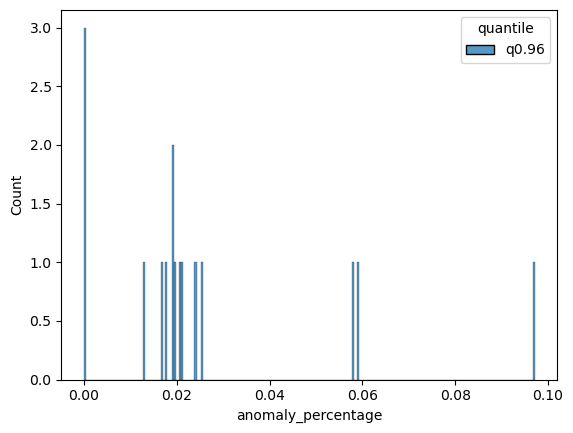

In [65]:
df_plot = results_df.loc[(results_df.map == 'MTsat') & (results_df.ae == 'autoencoder') & (results_df.re_map == 'l1_re_map') , :] # & (results_df.label == 3)
sns.histplot(data=df_plot, x='anomaly_percentage', hue='quantile', multiple='stack', bins=200)
# plt.xlim(0, 0.25)

In [9]:
# df = pd.DataFrame()

ae_type = 'svae'
for map_type, chkpt_dict in CV_CHKPT_PATHS[ae_type].items():
    for cv_fold, ckpt_str in chkpt_dict.items():
        chkpt_path = Path(ckpt_str)
        exp_dir = chkpt_path.parent.parent.parent
        with open(exp_dir /'config_dump.yml', 'r') as f:
            exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

        root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
        md_df = pd.read_csv(this_path/'bids_3t.csv')
        md_df_hc = md_df[md_df['group'] == 0]

        md_df_pd = md_df[md_df['group'] == 1]
        subjs_to_drop = ['sub-058', 'sub-016']
        for drop_id in subjs_to_drop:
            md_df_pd.drop(md_df_pd[md_df_pd.id == drop_id].index, inplace=True)
        md_df_pd.reset_index(drop=True, inplace=True)

        _, test_index = get_indexes_from_cfg(chkpt_path)
        md_df_hc_test = md_df_hc.iloc[test_index, :]

        subjects_list = md_df_hc_test['id'].tolist()
        progress_bar = tqdm(subjects_list, desc=f'Processing HC {map_type}-{cv_fold}', total=len(subjects_list), ncols=110)
        for subject in progress_bar:
            get_anomaly_percentages_NORMCV(subject, map=map_type, cv_fold=cv_fold, ae_type=ae_type)
            
        subjects_list = md_df_pd['id'].tolist()
        progress_bar = tqdm(subjects_list, desc=f'Processing PD {map_type}-{cv_fold}', total=len(subjects_list), ncols=110)
        for subject in progress_bar:
            get_anomaly_percentages_NORMCV(subject, map=map_type, cv_fold=cv_fold, ae_type=ae_type)

Processing PD PD_R2scorr-cv_4: 100%|██████████████████████████████████████████| 47/47 [05:24<00:00,  6.90s/it]


### RE group analysis
Check first if anova test changes when using the normal sample imbalance, and a balanced one

#### CV

In [24]:
# SAMPLING SUBJECTS
ae_type = 'svae'
for map_type, chkpt_dict in CV_CHKPT_PATHS[ae_type].items():
    for cv_fold, ckpt_str in chkpt_dict.items():
        chkpt_path = Path(ckpt_str)
        exp_dir = chkpt_path.parent.parent.parent
        with open(exp_dir /'config_dump.yml', 'r') as f:
            exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

        root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
        md_df = pd.read_csv(this_path/'bids_3t.csv')
        md_df_hc = md_df[md_df['group'] == 0]

        md_df_pd = md_df[md_df['group'] == 1]
        subjs_to_drop = ['sub-058', 'sub-016']
        for drop_id in subjs_to_drop:
            md_df_pd.drop(md_df_pd[md_df_pd.id == drop_id].index, inplace=True)
        md_df_pd.reset_index(drop=True, inplace=True)

        _, test_index = get_indexes_from_cfg(chkpt_path)
        md_df_hc_test = md_df_hc.iloc[test_index, :]
        print(f'Fold: {cv_fold} \n -- HC: {len(md_df_hc_test)}, PD: {len(md_df_pd)}')
        print(f'-- HC: {md_df_hc_test.id.values.tolist()}')
        print(f'Gender: \n {md_df_hc_test.sex.value_counts()}')  
        print(f'Mean age: {md_df_hc_test.age.mean()} ')

        # sample PD patients
        sampled_pd_ids = sample_patients_match(md_df_pd, md_df_hc_test, 2, 3) 
        # sampled_pd_ids = sample_patients_without_replacement(md_df_pd, md_df_hc_test, 2*len(md_df_hc_test), 5) 

        print(f'-- PD: {sampled_pd_ids}')
        sampled_pd_df = md_df_pd.loc[md_df_pd.id.isin(sampled_pd_ids), :]
        print(f'Gender: \n {sampled_pd_df.sex.value_counts()}')
        print(f'Mean age: {sampled_pd_df.age.mean()} \n')
        # break   
    break

Fold: cv_0 
 -- HC: 5, PD: 47
-- HC: ['sub-012', 'sub-020', 'sub-028', 'sub-030', 'sub-057']
Gender: 
 0    3
1    2
Name: sex, dtype: int64
Mean age: 74.4 
-- PD: ['sub-009', 'sub-046', 'sub-037', 'sub-019', 'sub-072', 'sub-039', 'sub-035', 'sub-038', 'sub-024', 'sub-049']
Gender: 
 0    6
1    4
Name: sex, dtype: int64
Mean age: 73.1 

Fold: cv_1 
 -- HC: 5, PD: 47
-- HC: ['sub-033', 'sub-044', 'sub-047', 'sub-051', 'sub-067']
Gender: 
 0    3
1    2
Name: sex, dtype: int64
Mean age: 69.6 
-- PD: ['sub-040', 'sub-013', 'sub-056', 'sub-031', 'sub-018', 'sub-003', 'sub-043', 'sub-071', 'sub-074', 'sub-042']
Gender: 
 0    6
1    4
Name: sex, dtype: int64
Mean age: 67.4 

Fold: cv_2 
 -- HC: 5, PD: 47
-- HC: ['sub-027', 'sub-032', 'sub-048', 'sub-060', 'sub-068']
Gender: 
 0    3
1    2
Name: sex, dtype: int64
Mean age: 63.6 
-- PD: ['sub-015', 'sub-065', 'sub-046', 'sub-014', 'sub-061', 'sub-025', 'sub-049', 'sub-074', 'sub-024', 'sub-042']
Gender: 
 0    6
1    4
Name: sex, dtype: int

In [5]:
SAMPLE_CV = {
    'cv_0': {
        'HC': ['sub-012', 'sub-020', 'sub-028', 'sub-030', 'sub-057'],
        'PD': ['sub-009', 'sub-046', 'sub-037', 'sub-019', 'sub-072', 'sub-039', 'sub-035', 'sub-038', 'sub-024', 'sub-049']
    },
    'cv_1': {
        'HC': ['sub-033', 'sub-044', 'sub-047', 'sub-051', 'sub-067'],
        'PD': ['sub-040', 'sub-013', 'sub-056', 'sub-031', 'sub-018', 'sub-003', 'sub-043', 'sub-071', 'sub-074', 'sub-042']
    },
    'cv_2': {
        'HC': ['sub-027', 'sub-032', 'sub-048', 'sub-060', 'sub-068'],
        'PD': ['sub-015', 'sub-065', 'sub-046', 'sub-014', 'sub-061', 'sub-025', 'sub-049', 'sub-074', 'sub-024', 'sub-042']
    },
    'cv_3': {
        'HC': ['sub-022', 'sub-050', 'sub-064', 'sub-069'],
        'PD': ['sub-070', 'sub-062', 'sub-018', 'sub-043', 'sub-074', 'sub-008', 'sub-024', 'sub-042']
    },
    'cv_4': {
        'HC': ['sub-026', 'sub-034', 'sub-036', 'sub-054'],
        'PD': ['sub-014', 'sub-066', 'sub-053', 'sub-003', 'sub-061', 'sub-011', 'sub-004', 'sub-023']
    }
}

In [26]:
# atlas_types = ['synthseg', 'pd25']
# map_types = ['R2s_WLS1', 'PD_R2scorr'] # 'MTsat', 'R1', 
# ae_types = ['autoencoder', 'svae']

# for atlas_type in atlas_types:
#     for map_type in map_types:
#         for ae_type in ae_types:
#             print(f'Processing {atlas_type} {map_type} {ae_type}')
#             df_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/normative_cv/dfs/statistics_{atlas_type}_{map_type}_{ae_type}_stats.csv')
#             if df_path.exists():
#                 dfs = pd.read_csv(df_path)
#             else:
#                 dfs = pd.DataFrame()
#                 for cv_fold, subjects_dict in SAMPLE_CV.items():    
#                     for group, subjects in subjects_dict.items():            
#                         for subject in subjects:
#                             for re_map in maps:
#                                 base_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/normative_cv/{subject}')
#                                 map_path = base_path / f'{map_type}/{ae_type}/{cv_fold}/odim_{subject}_{re_map}.nii'
#                                 map_img = nib.load(str(map_path)).get_fdata()
#                                 df = get_statistics_from_map(map_img, subject, group, atlas_type=atlas_type)
#                                 df['map_type'] = re_map
#                                 df['cv_fold'] = cv_fold
#                                 dfs = pd.concat([dfs, df], axis=0)
#                             # break
#                         dfs.reset_index(drop=True, inplace=True)
#                         dfs.to_csv(df_path, index=False)

maps = ['l1_re_map', 'ssim_re_map']
atlas_type = 'pd25'
map_type = 'R1'
ae_type = 'autoencoder'

df_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/normative_cv/dfs/statistics_{atlas_type}_{map_type}_{ae_type}_stats.csv')
if df_path.exists():
    dfs = pd.read_csv(df_path)
else:
    dfs = pd.DataFrame()
    for cv_fold, subjects_dict in SAMPLE_CV.items():    
        for group, subjects in subjects_dict.items():            
            for subject in subjects:
                for re_map in maps:
                    base_path = Path(f'/mnt/scratch/7TPD/mpm_run_acu/normative_cv/{subject}')
                    map_path = base_path / f'{map_type}/{ae_type}/{cv_fold}/odim_{subject}_{re_map}.nii'
                    map_img = nib.load(str(map_path)).get_fdata()
                    df = get_statistics_from_map(map_img, subject, group, atlas_type=atlas_type)
                    df['map_type'] = re_map
                    df['cv_fold'] = cv_fold
                    dfs = pd.concat([dfs, df], axis=0)
                # break
            dfs.reset_index(drop=True, inplace=True)
            dfs.to_csv(df_path, index=False)

dfs = rename_labels(dfs, atlas_type=atlas_type)

In [27]:
dfs

,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type,cv_fold
0,background,HC,pd25,sub-012,4921540,0.014548,0.046376,0.000306,0.974004,0.000000,0.009999,l1_re_map,cv_0
1,left_red_nucleus,HC,pd25,sub-012,168,0.031369,0.023105,0.025942,0.117400,0.000670,0.025711,l1_re_map,cv_0
2,right_red_nucleus,HC,pd25,sub-012,157,0.027632,0.020891,0.023893,0.090079,0.000035,0.027276,l1_re_map,cv_0
3,left_substantia_nigra,HC,pd25,sub-012,331,0.028922,0.022875,0.024682,0.132357,0.000009,0.033101,l1_re_map,cv_0
4,right_substantia_nigra,HC,pd25,sub-012,369,0.028360,0.022208,0.023298,0.108626,0.000020,0.030839,l1_re_map,cv_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,right_globus_pallidus_externa,PD,pd25,sub-023,866,0.659093,0.178489,0.677644,0.945641,0.169113,0.290713,ssim_re_map,cv_4
2342,left_globus_pallidus_interna,PD,pd25,sub-023,380,0.735072,0.128851,0.745755,0.939851,0.408188,0.209799,ssim_re_map,cv_4
2343,right_globus_pallidus_interna,PD,pd25,sub-023,414,0.781693,0.118417,0.809797,0.949648,0.370446,0.146872,ssim_re_map,cv_4
2344,left_thalamus,PD,pd25,sub-023,4948,0.823106,0.077690,0.827897,0.989289,0.465346,0.107677,ssim_re_map,cv_4


In [28]:
fos_type = 'mean'
cv_folds = ['cv_0', 'cv_1', 'cv_2', 'cv_3', 'cv_4']
test_stats = []
for cv_fold in cv_folds:
    for map in maps: 
        for label in dfs.label.unique():
            # label = 26
            test_dict = {}
            df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label) & (dfs.cv_fold == cv_fold), :]
            # print(f'Processing {map} {label}')
            f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                    df_lab.loc[df_lab.group == 'HC', fos_type].values)
            t_test, t_p_value = ttest_ind(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                        df_lab.loc[df_lab.group == 'HC', fos_type].values,
                                        equal_var=False,
                                        permutations=1000)
            test_dict['cv_fold'] = cv_fold
            test_dict['map'] = map
            test_dict['fos_type'] = fos_type
            test_dict['label'] = label
            test_dict['f_oneway'] = f_stat
            test_dict['p_value'] = p_value
            test_dict['t_test'] = t_test
            test_dict['t_p_value'] = t_p_value
            test_stats.append(test_dict)
            
test_stats = pd.DataFrame(test_stats)

In [29]:
alpha = 0.05
bestfos = test_stats.loc[(test_stats.p_value < alpha) & (test_stats.t_p_value < alpha), :]
bestfos

,cv_fold,map,fos_type,label,f_oneway,p_value,t_test,t_p_value
149,cv_4,l1_re_map,mean,left_globus_pallidus_interna,6.217771,0.031796,3.568291,0.012121


#### OG

In [2]:
# create datasets
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/vqvae_models/normative_vqvae_run3_R2s_WLS1/config_dump.yml')
with open(ckpt_path, 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

map_type = exp_cfg['dataset']['map_type']
augmentations = tio.Compose([])
data_hc = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **exp_cfg['dataset'])
data_hc.prepare_data()
data_hc.setup()

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,
                            augment=augmentations,
                            **exp_cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()

print(f'PD subjects: {len(data_pd.md_df)}, HC val subjects: {len(data_hc.md_df_val)}')
pd_subjects = data_pd.md_df.id.values.tolist()
hc_val_subjects = data_hc.md_df_val.id.values.tolist()

PD subjects: 47, HC val subjects: 7


In [3]:
# subsets selection for evaluation

# always use the same HC val subjects
hc_val_subjects = data_hc.md_df_val.id.values.tolist()

# subsample PD subjects to match mean age and sex frequency ratio of HC val
# pd_subjects = ['sub-006', 'sub-025', 'sub-014', 'sub-019', 
#                'sub-011', 'sub-049', 'sub-024', 'sub-004', 
#                'sub-018', 'sub-008', 'sub-003', 'sub-023', 
#                'sub-035', 'sub-065', 'sub-061', 'sub-015', 
#                'sub-029', 'sub-043', 'sub-071', 'sub-056']
pd_subjects = ['sub-003', 'sub-029', 'sub-024', 'sub-049', 
               'sub-053', 'sub-056', 'sub-014', 'sub-004', 
               'sub-018', 'sub-065', 'sub-015', 'sub-011', 'sub-061', 'sub-043']

In [63]:
maps = ['l1_re_map', 'mse_re_map', 'l2_re_map', 'ssim_re_map']
atlas_type = 'pd25'
map_type = 'PD_R2scorr'
ae_type = 'vqvae'

df_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/dfs/statistics_{atlas_type}_{map_type}_{ae_type}_stats.csv')
if df_path.exists():
    dfs = pd.read_csv(df_path)
else:
    dfs = pd.DataFrame()
    for subject in hc_val_subjects:
        for re_map in maps:
            base_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/{subject}')
            map_path = base_path / f'{map_type}/{ae_type}/odim_{subject}_{re_map}.nii'
            map_img = nib.load(str(map_path)).get_fdata()
            df = get_statistics_from_map(map_img, subject, 'HC', atlas_type=atlas_type)
            df['map_type'] = re_map
            dfs = pd.concat([dfs, df], axis=0)
        # break

    for subject in pd_subjects:
        for re_map in maps:
            base_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/{subject}')
            map_path = base_path / f'{map_type}/{ae_type}/odim_{subject}_{re_map}.nii'
            map_img = nib.load(str(map_path)).get_fdata()
            df = get_statistics_from_map(map_img, subject, 'PD', atlas_type=atlas_type) 
            df['map_type'] = re_map
            dfs = pd.concat([dfs, df], axis=0)
        # break
    dfs.reset_index(drop=True, inplace=True)
    dfs.to_csv(df_path, index=False)

if atlas_type == 'pd25':
    replace_dict = {1: 'left_red_nucleus',
                    3: 'left_substantia_nigra',
                    5: 'left_subthalamic_nucleus',
                    7: 'left_caudate',
                    9: 'left_putamen',
                    11: 'left_globus_pallidus_externa',
                    13: 'left_globus_pallidus_interna',
                    15: 'left_thalamus',
                    2: 'right_red_nucleus',
                    4: 'right_substantia_nigra',
                    6: 'right_subthalamic_nucleus',
                    8: 'right_caudate',
                    10: 'right_putamen',
                    12: 'right_globus_pallidus_externa',
                    14: 'right_globus_pallidus_interna',
                    16: 'right_thalamus',}
    dfs.label.replace(replace_dict, inplace=True)
else:
    replace_dict = {0: 'background',
                    2: 'left_cerebral_white_matter',
                    3: 'left_cerebral_cortex',
                    4: 'left_lateral_ventricle',
                    5: 'left_inferior_lateral_ventricle',
                    7: 'left_cerebellum_white_matter',
                    8: 'left_cerebellum_cortex',
                    10: 'left_thalamus',
                    11: 'left_caudate',
                    12: 'left_putamen',
                    13: 'left_pallidum',
                    14: 'third_ventricle',
                    15: 'fourth_ventricle',
                    16: 'brain_stem',
                    17: 'left_hippocampus',
                    18: 'left_amygdala',
                    24: 'csf',
                    26: 'left_accumbens_area',
                    28: 'left_ventral_diencephalon',
                    41: 'right_cerebral_white_matter',
                    42: 'right_cerebral_cortex',
                    43: 'right_lateral_ventricle',
                    44: 'right_inferior_lateral_ventricle',
                    46: 'right_cerebellum_white_matter',
                    47: 'right_cerebellum_cortex',
                    49: 'right_thalamus',
                    50: 'right_caudate',
                    51: 'right_putamen',
                    52: 'right_pallidum',
                    53: 'right_hippocampus',
                    54: 'right_amygdala',
                    58: 'right_accumbens_area',
                    60: 'right_ventral_diencephalon'}
    dfs.label.replace(replace_dict, inplace=True)

In [64]:
# maps = ['l1_re_map', 'mse_re_map', 'l2_re_map', 'ssim_re_map']
fos_type = 'mean'
test_stats = []
for map in maps: 
    for label in dfs.label.unique():
        # label = 26
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        # print(f'Processing {map} {label}')
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                   df_lab.loc[df_lab.group == 'HC', fos_type].values)
        t_test, t_p_value = ttest_ind(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                      df_lab.loc[df_lab.group == 'HC', fos_type].values,
                                      equal_var=False,
                                      permutations=1000)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        test_dict['t_test'] = t_test
        test_dict['t_p_value'] = t_p_value
        test_stats.append(test_dict)
        
test_stats = pd.DataFrame(test_stats)

if atlas_type == 'pd25':
    replace_dict = {1: 'left_red_nucleus',
                    3: 'left_substantia_nigra',
                    5: 'left_subthalamic_nucleus',
                    7: 'left_caudate',
                    9: 'left_putamen',
                    11: 'left_globus_pallidus_externa',
                    13: 'left_globus_pallidus_interna',
                    15: 'left_thalamus',
                    2: 'right_red_nucleus',
                    4: 'right_substantia_nigra',
                    6: 'right_subthalamic_nucleus',
                    8: 'right_caudate',
                    10: 'right_putamen',
                    12: 'right_globus_pallidus_externa',
                    14: 'right_globus_pallidus_interna',
                    16: 'right_thalamus',}
    test_stats.label.replace(replace_dict, inplace=True)
else:
    replace_dict = {0: 'background',
                    2: 'left_cerebral_white_matter',
                    3: 'left_cerebral_cortex',
                    4: 'left_lateral_ventricle',
                    5: 'left_inferior_lateral_ventricle',
                    7: 'left_cerebellum_white_matter',
                    8: 'left_cerebellum_cortex',
                    10: 'left_thalamus',
                    11: 'left_caudate',
                    12: 'left_putamen',
                    13: 'left_pallidum',
                    14: 'third_ventricle',
                    15: 'fourth_ventricle',
                    16: 'brain_stem',
                    17: 'left_hippocampus',
                    18: 'left_amygdala',
                    24: 'csf',
                    26: 'left_accumbens_area',
                    28: 'left_ventral_diencephalon',
                    41: 'right_cerebral_white_matter',
                    42: 'right_cerebral_cortex',
                    43: 'right_lateral_ventricle',
                    44: 'right_inferior_lateral_ventricle',
                    46: 'right_cerebellum_white_matter',
                    47: 'right_cerebellum_cortex',
                    49: 'right_thalamus',
                    50: 'right_caudate',
                    51: 'right_putamen',
                    52: 'right_pallidum',
                    53: 'right_hippocampus',
                    54: 'right_amygdala',
                    58: 'right_accumbens_area',
                    60: 'right_ventral_diencephalon'}
    test_stats.label.replace(replace_dict, inplace=True)

alpha = 0.05
bestfos = test_stats.loc[(test_stats.p_value < alpha) & (test_stats.t_p_value < alpha), :]
bestfos

,map,fos_type,label,f_oneway,p_value,t_test,t_p_value
5,l1_re_map,mean,left_subthalamic_nucleus,4.748901,0.042108,2.531516,0.009
39,l2_re_map,mean,left_subthalamic_nucleus,4.748901,0.042108,2.531516,0.010


In [7]:
def rename_labels_for_plot(df, atlas_type: str = 'pd25'):

    if atlas_type == 'pd25':
        replace_dict = {'left_red_nucleus': 'left RN',
                        'left_substantia_nigra': 'left SNc',
                        'left_subthalamic_nucleus': 'left STN',
                        'left_caudate': 'left Cau',
                        'left_putamen': 'left Put',
                        'left_globus_pallidus_externa': 'left GPe',
                        'left_globus_pallidus_interna': 'left GPi',
                        'left_thalamus': 'left Th',
                        'right_red_nucleus': 'right RN',
                        'right_substantia_nigra': 'right SNc',
                        'right_subthalamic_nucleus': 'right STN',
                        'right_caudate': 'right Cau',
                        'right_putamen': 'right Put',
                        'right_globus_pallidus_externa': 'right GPe',
                        'right_globus_pallidus_interna': 'right GPi',
                        'right_thalamus': 'right Th'}
        df.label.replace(replace_dict, inplace=True)
        
        return df
    else:
        # replace_dict = {0: 'background',
        #                 2: 'left_cerebral_white_matter',
        #                 3: 'left_cerebral_cortex',
        #                 4: 'left_lateral_ventricle',
        #                 5: 'left_inferior_lateral_ventricle',
        #                 7: 'left_cerebellum_white_matter',
        #                 8: 'left_cerebellum_cortex',
        #                 10: 'left_thalamus',
        #                 11: 'left_caudate',
        #                 12: 'left_putamen',
        #                 13: 'left_pallidum',
        #                 14: 'third_ventricle',
        #                 15: 'fourth_ventricle',
        #                 16: 'brain_stem',
        #                 17: 'left_hippocampus',
        #                 18: 'left_amygdala',
        #                 24: 'csf',
        #                 26: 'left_accumbens_area',
        #                 28: 'left_ventral_diencephalon',
        #                 41: 'right_cerebral_white_matter',
        #                 42: 'right_cerebral_cortex',
        #                 43: 'right_lateral_ventricle',
        #                 44: 'right_inferior_lateral_ventricle',
        #                 46: 'right_cerebellum_white_matter',
        #                 47: 'right_cerebellum_cortex',
        #                 49: 'right_thalamus',
        #                 50: 'right_caudate',
        #                 51: 'right_putamen',
        #                 52: 'right_pallidum',
        #                 53: 'right_hippocampus',
        #                 54: 'right_amygdala',
        #                 58: 'right_accumbens_area',
        #                 60: 'right_ventral_diencephalon'}
        # df.label.replace(replace_dict, inplace=True)

        return df

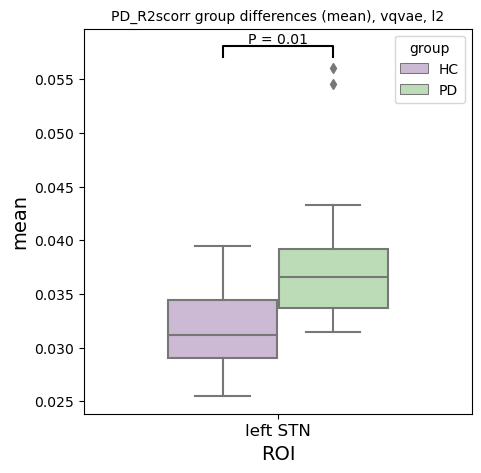

In [68]:
re_to_plot = 'l2_re_map'
fos_type_to_plot = fos_type
pval_to_plot = bestfos.loc[bestfos.map == re_to_plot, 't_p_value'].values[0]
# roi_to_plot = test_stats.loc[test_stats.map == re_to_plot, 'label'].values[0]
df_to_plot = dfs.loc[(dfs.map_type.isin([re_to_plot])) & (dfs.label.isin(['left_subthalamic_nucleus'])), :]
df_to_plot = rename_labels_for_plot(df_to_plot, atlas_type)

plt.figure(figsize=(5, 5))
sns.boxplot(data=df_to_plot, x='label', y=fos_type_to_plot, hue='group', width=0.8, palette='PRGn') # palette='PRGn'

# statistical annotation
x1, x2 = -0.2, 0.2 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_to_plot[fos_type_to_plot].max() + 0.001, 0.001, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"P = {pval_to_plot}", ha='center', va='bottom', color=col)

plt.xlabel('ROI', fontsize=14)
plt.ylabel(f'{fos_type_to_plot}', fontsize=14)
plt.xticks(fontsize=12) # ticks=[0], labels=['left accumbens area'], 
plt.title(f"{map_type} group differences ({fos_type_to_plot}), {ae_type}, {re_to_plot.split('_')[0]}", fontsize=10)
# plt.grid()
plt.show()

In [122]:
test_stats.loc[test_stats.label.isin(['left_substantia_nigra', 'right_substantia_nigra']) & (test_stats.map == 'mse_re_map'), :]

,map,fos_type,label,f_oneway,p_value,t_test,t_p_value
20,mse_re_map,median,left_substantia_nigra,3.521832,0.076011,2.125148,0.046
21,mse_re_map,median,right_substantia_nigra,5.593503,0.028820,2.884071,0.010


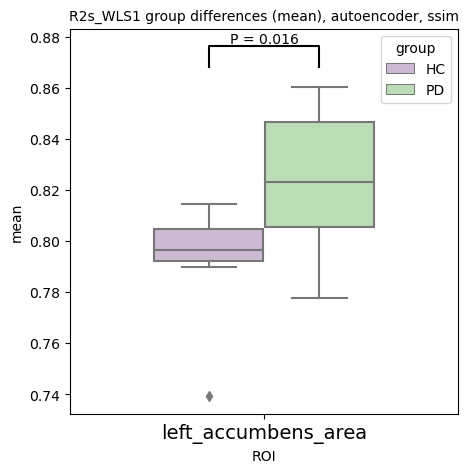

In [115]:
re_to_plot = 'ssim_re_map'
fos_type_to_plot = fos_type
pval_to_plot = bestfos.loc[bestfos.map == re_to_plot, 't_p_value'].values[0]
roi_to_plot = bestfos.loc[bestfos.map == re_to_plot, 'label'].values[0]
df_to_plot = dfs.loc[(dfs.map_type.isin([re_to_plot])) & (dfs.label == roi_to_plot), :]

plt.figure(figsize=(5, 5))
sns.boxplot(data=df_to_plot, x='label', y=fos_type_to_plot, hue='group', width=0.8, palette='PRGn')

# statistical annotation
x1, x2 = -0.2, 0.2 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_to_plot[fos_type_to_plot].max() + 0.008, 0.008, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"P = {pval_to_plot}", ha='center', va='bottom', color=col)
plt.xlabel('ROI')
plt.xticks(fontsize=14)
plt.title(f"{map_type} group differences ({fos_type_to_plot}), {ae_type}, {re_to_plot.split('_')[0]}", fontsize=10)
# plt.grid()
plt.show()

In [30]:
replace_dict = {1: 'left_red_nucleus',
                3: 'left_substantia_nigra',
                5: 'left_subthalamic_nucleus',
                7: 'left_caudate',
                9: 'left_putamen',
                11: 'left_globus_pallidus_externa',
                13: 'left_globus_pallidus_interna',
                15: 'left_thalamus',
                2: 'right_red_nucleus',
                4: 'right_substantia_nigra',
                6: 'right_subthalamic_nucleus',
                8: 'right_caudate',
                10: 'right_putamen',
                12: 'right_globus_pallidus_externa',
                14: 'right_globus_pallidus_interna',
                16: 'right_thalamus',}
test_stats.label.replace(replace_dict, inplace=True)
# df.to_csv('xai_outs/f_oneway_results.csv')
map_type = 'l2_re_map'
test_type = 'f_oneway'
value_p = 'p_value'
results = test_stats.loc[(test_stats.map == map_type), [test_type, 'label', value_p]]
results.sort_values(by=value_p) # loc[df.p_value <= 0.005, :]

,f_oneway,label,p_value
38,5.801679,right_substantia_nigra,0.026326
35,3.797001,left_red_nucleus,0.066268
37,3.565388,left_substantia_nigra,0.074363
46,3.365371,right_globus_pallidus_externa,0.082290
36,3.239052,right_red_nucleus,0.087803
47,3.123368,left_globus_pallidus_interna,0.093235
39,3.010177,left_subthalamic_nucleus,0.098936
48,1.906607,right_globus_pallidus_interna,0.183368
45,1.697993,left_globus_pallidus_externa,0.208122
40,1.358927,right_subthalamic_nucleus,0.258149


In [ ]:
dfs.label.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [27]:
map_type = 'l1_re_map'
test_type = 't_test'
value_p = 't_p_value'
results = test_stats.loc[(test_stats.map == map_type), [test_type, 'label', value_p]]
results.sort_values(by=value_p) # loc[df.p_value <= 0.005, :]

,t_test,label,t_p_value
4,2.288027,right_substantia_nigra,0.034977
12,2.255798,right_globus_pallidus_externa,0.036980
5,1.987626,left_subthalamic_nucleus,0.065046
13,1.941660,left_globus_pallidus_interna,0.070223
14,1.767996,right_globus_pallidus_interna,0.094386
3,1.670119,left_substantia_nigra,0.120727
2,1.602255,right_red_nucleus,0.134768
1,1.558929,left_red_nucleus,0.144570
11,1.499562,left_globus_pallidus_externa,0.150463
9,1.164482,left_putamen,0.258851


### ROC Curves

#### CV

In [6]:
SAMPLE_CV = {
    'cv_0': {
        'HC': ['sub-012', 'sub-020', 'sub-028', 'sub-030', 'sub-057'],
        'PD': ['sub-009', 'sub-046', 'sub-037', 'sub-019', 'sub-072', 'sub-039', 'sub-035', 'sub-038', 'sub-024', 'sub-049']
    },
    'cv_1': {
        'HC': ['sub-033', 'sub-044', 'sub-047', 'sub-051', 'sub-067'],
        'PD': ['sub-040', 'sub-013', 'sub-056', 'sub-031', 'sub-018', 'sub-003', 'sub-043', 'sub-071', 'sub-074', 'sub-042']
    },
    'cv_2': {
        'HC': ['sub-027', 'sub-032', 'sub-048', 'sub-060', 'sub-068'],
        'PD': ['sub-015', 'sub-065', 'sub-046', 'sub-014', 'sub-061', 'sub-025', 'sub-049', 'sub-074', 'sub-024', 'sub-042']
    },
    'cv_3': {
        'HC': ['sub-022', 'sub-050', 'sub-064', 'sub-069'],
        'PD': ['sub-070', 'sub-062', 'sub-018', 'sub-043', 'sub-074', 'sub-008', 'sub-024', 'sub-042']
    },
    'cv_4': {
        'HC': ['sub-026', 'sub-034', 'sub-036', 'sub-054'],
        'PD': ['sub-014', 'sub-066', 'sub-053', 'sub-003', 'sub-061', 'sub-011', 'sub-004', 'sub-023']
    }
}

In [7]:
# Retrieving all anomaly percentages for all subjects

def get_classification_results_NORMCV(hc_val_subjects: List,
                               pd_subjects: List,
                               map_type: str, 
                               ae_type: str,
                               re_map_type: str,
                               atlas_type: str,
                               cv_fold: str,
                               compute_metrics: bool = True,
                               quantiles: List = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99', 'q1.0']):
    
    # select an experiment
    # map_type = 'MTsat' # MTsat, R1, PD_R2scorr, R2s_WLS1
    # ae_type = 'autoencoder'
    # re_map_type = 'l2_re_map' # ssim
    # atlas_type = 'pd25'
    # quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99']

    # just to get labels 
    subject = 'sub-015'
    sub_results_path = Path('/mnt/scratch/7TPD/mpm_run_acu/normative_cv')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    if atlas_type == 'pd25':
        pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
    else:
        pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'

    atlas_labels = np.unique(nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8))[1:]

    scores = {label: {quant: [] for quant in quantiles} for label in atlas_labels}
    targets = []
    for subject in hc_val_subjects:
        # print(f'Processing {subject}')
        df = pd.read_csv(sub_results_path/f'{subject}/{map_type}/{ae_type}/{cv_fold}/anomaly_percentages_{cv_fold}.csv')
        sub_df = df.loc[(df.re_map == re_map_type) & (df.atlas == atlas_type), :]
        for label in atlas_labels:
                for quant in quantiles:
                    lab_df = sub_df.loc[sub_df.label == label, :]
                    scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
        targets.append(0)
        
    for subject in pd_subjects:
        # print(f'Processing {subject}')
        df = pd.read_csv(sub_results_path/f'{subject}/{map_type}/{ae_type}/{cv_fold}/anomaly_percentages_{cv_fold}.csv')
        sub_df = df.loc[(df.re_map == re_map_type) & (df.atlas == atlas_type), :]
        for label in atlas_labels:
                for quant in quantiles:
                    lab_df = sub_df.loc[sub_df.label == label, :]
                    scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
        targets.append(1)

    if compute_metrics:
        # compute performance metrics
        class_results = [] #{label: {quant: [] for quant in quantiles} for label in atlas_labels}
        for label, quant_scores in scores.items():
            for quant, subj_scores in quant_scores.items():
                res = {}
                fpr, tpr, thresholds = metrics.roc_curve(targets, subj_scores, pos_label=1)
                g_means = np.sqrt(tpr * (1-fpr))
                precision, recall, _ = metrics.precision_recall_curve(targets, subj_scores, pos_label=1)
                roc_auc = metrics.auc(fpr, tpr)
                prc_auc = metrics.auc(recall, precision)
                res['label'] = label
                res['quant'] = quant
                res['fpr'] = fpr
                res['tpr'] = tpr
                res['auroc'] = roc_auc
                res['g_means'] = g_means
                res['gmean'] = np.max(g_means)
                res['pat_threshold'] = thresholds[np.argmax(g_means)]
                res['precision'] = precision
                res['recall'] = recall
                res['auprc'] = prc_auc
                res['map_type'] = map_type
                res['ae_type'] = ae_type
                res['re_map_type'] = re_map_type
                res['atlas_type'] = atlas_type
                res['cv_fold'] = cv_fold
                class_results.append(res)

        return pd.DataFrame(class_results)
    else:
         return scores, targets

In [24]:
# select an experiment
map_types = ['MTsat', 'R1', 'PD_R2scorr', 'R2s_WLS1'] # MTsat, R1, PD_R2scorr, R2s_WLS1
ae_type = ['autoencoder', 'svae']
re_map_type = ['ssim_re_map', 'l1_re_map'] # ssim
atlas_type = 'pd25'

save_path = Path('/mnt/scratch/7TPD/mpm_run_acu/normative_cv/dfs')
final_results = pd.DataFrame()
for map_type in map_types:
    for cv_fold, subjects_dict in SAMPLE_CV.items():
        for ae in ae_type:  
            for re_map in re_map_type:
                # print(f'Processing {cv_fold}: {map_type} {ae} {re_map}')
                hc_val_subjects = subjects_dict['HC']
                pd_subjects = subjects_dict['PD']
                class_results = get_classification_results_NORMCV(hc_val_subjects,
                                                                    pd_subjects,
                                                                    map_type, 
                                                                    ae, 
                                                                    re_map, 
                                                                    atlas_type,
                                                                    cv_fold)
                final_results = pd.concat([final_results, class_results], axis=0)
    final_results.to_csv(df_path, index=False)
    # break


In [35]:
map_type = 'MTsat'
atlas_type = 'pd25'
ae_type = 'autoencoder'
re_map_type = 'l1_re_map'
quant = 'q0.99'
final_results = pd.read_csv(Path(f'/mnt/scratch/7TPD/mpm_run_acu/normative_cv/dfs/final_results_{map_type}_{atlas_type}.csv'))
res_to_plot = final_results.loc[(final_results.map_type == map_type) & (final_results.ae_type == ae_type) & (final_results.re_map_type == re_map_type)  & (final_results.quant == quant), :] # & (final_results.label == 2)
print(res_to_plot.columns)

Index(['label', 'quant', 'fpr', 'tpr', 'auroc', 'g_means', 'gmean',
       'pat_threshold', 'precision', 'recall', 'auprc', 'map_type', 'ae_type',
       're_map_type', 'atlas_type', 'cv_fold'],
      dtype='object')


In [41]:
res_to_plot.loc[res_to_plot.label == 16, ['auroc', 'cv_fold']]

,auroc,cv_fold
382,0.6400,cv_0
1150,0.8200,cv_1
1918,0.2000,cv_2
2686,0.4375,cv_3
3454,0.5000,cv_4


In [36]:
res_to_plot.groupby(['label'], as_index=False).agg({'gmean': ['mean', 'std'], 'auroc': ['mean', 'std'], 'auprc': ['mean', 'std']})

label     gmean               auroc               auprc          
              mean       std      mean       std      mean       std
0      1  0.645573  0.101464  0.567750  0.090045  0.752003  0.077302
1      2  0.702450  0.019833  0.630125  0.060513  0.765750  0.049140
2      3  0.668501  0.079896  0.624750  0.126511  0.799765  0.088146
3      4  0.621678  0.104684  0.549500  0.096179  0.751639  0.051268
4      5  0.524093  0.103543  0.502875  0.100058  0.710015  0.107115
5      6  0.575240  0.051225  0.552750  0.039295  0.757036  0.028955
6      7  0.640919  0.055592  0.602000  0.052875  0.744261  0.062516
7      8  0.644233  0.072580  0.572000  0.106370  0.744286  0.093687
8      9  0.646854  0.075663  0.553000  0.096653  0.769896  0.075513
9     10  0.606214  0.121218  0.557000  0.106042  0.753811  0.064378
10    11  0.618207  0.079611  0.518250  0.069696  0.670311  0.067196
11    12  0.613344  0.075494  0.521000  0.078678  0.699144  0.075148
12    13  0.514711  0.114959  0.506750  0.111094  0.709305  0.076849
13    14  0.572473  0.053322  0.520125  0.082706  0.724261  0.053478
14    15  0.577830  0.115174  0.446000  0.174415  0.642231  0.120358
15    16  0.602369  0.172850  0.519500  0.231303  0.708370  0.145520

<Axes: title={'center': 'auroc'}, xlabel='label'>

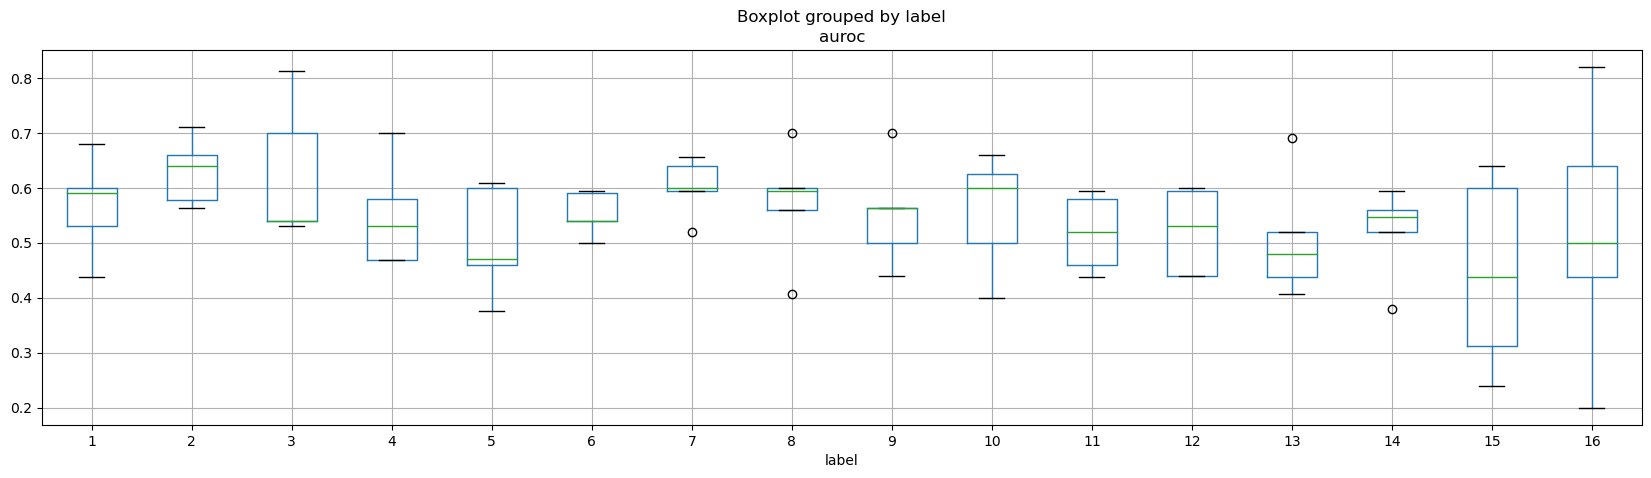

In [39]:
res_to_plot.boxplot(column='auroc', by='label', figsize=(20, 5))

#### OG

In [3]:
## PLOT ROC
def plot_roc(labels, preds, flag, model_name, n_classes):
    '''param : labels  --> True classification label
                preds  --> Predicted classification label
                flag   --> Boolean variable to determine if the ROC curves would be plotted (flag==True) or not (flag==False)
                clf    --> String containing the model's name
      return : roc_auc --> Dictionary of AUC values for each class'''  

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    colors = ['#f06e93', '#327ba8']
    for i in range(n_classes):
        actuals = (np.array(labels) == i+1).astype(np.uint8)  # Creating a one-vs-rest array for each class
        print(actuals.shape)
        print(preds.shape)
        fpr[i], tpr[i], _ = metrics.roc_curve(actuals, preds[:, i])  # Computing the FPR and TPR
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])  # Computing the AUC values for class i

    if(flag == True):  # If flag is True, then display the ROC curves
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve for {0} (area = {1:0.2f})'.format('Cancer/No Cancer', roc_auc[i]))  # roc_auc_score

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic [ROC] for {0}'.format(model_name))
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc


In [4]:
# create datasets
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/vqvae_models/normative_vqvae_run3_R2s_WLS1/config_dump.yml')
with open(ckpt_path, 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

map_type = exp_cfg['dataset']['map_type']
augmentations = tio.Compose([])
data_hc = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **exp_cfg['dataset'])
data_hc.prepare_data()
data_hc.setup()

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,
                            augment=augmentations,
                            **exp_cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()

print(f'PD subjects: {len(data_pd.md_df)}, HC val subjects: {len(data_hc.md_df_val)}')
pd_subjects = data_pd.md_df.id.values.tolist()
hc_val_subjects = data_hc.md_df_val.id.values.tolist()

PD subjects: 47, HC val subjects: 7


In [3]:
# subsample PD subjects matching sex and mean age of HC val
md_df_hc_val = data_hc.md_df_val
md_df_pd = data_pd.md_df

print(md_df_hc_val.sex.value_counts())
print(md_df_hc_val.age.mean())

0    5
1    2
Name: sex, dtype: int64
66.85714285714286


In [23]:
# sampled_ids = sample_patients(md_df_pd, md_df_hc_val, 14, age_tolerance=7)
# print(sampled_ids)
# sampled_pd_df = md_df_pd.loc[md_df_pd.id.isin(sampled_ids), :]
# print(sampled_pd_df.sex.value_counts())
# print(sampled_pd_df.age.mean())

['sub-003', 'sub-029', 'sub-024', 'sub-049', 'sub-053', 'sub-056', 'sub-014', 'sub-004', 'sub-018', 'sub-065', 'sub-015', 'sub-011', 'sub-061', 'sub-043']
0    10
1     4
Name: sex, dtype: int64
66.64285714285714


In [5]:
# subsets selection for evaluation

# always use the same HC val subjects
hc_val_subjects = data_hc.md_df_val.id.values.tolist()

# subsample PD subjects to match mean age and sex frequency ratio of HC val
# pd_subjects = ['sub-006', 'sub-025', 'sub-014', 'sub-019', 
#                'sub-011', 'sub-049', 'sub-024', 'sub-004', 
#                'sub-018', 'sub-008', 'sub-003', 'sub-023', 
#                'sub-035', 'sub-065', 'sub-061', 'sub-015', 
#                'sub-029', 'sub-043', 'sub-071', 'sub-056']
pd_subjects = ['sub-003', 'sub-029', 'sub-024', 'sub-049', 
               'sub-053', 'sub-056', 'sub-014', 'sub-004', 
               'sub-018', 'sub-065', 'sub-015', 'sub-011', 'sub-061', 'sub-043']

In [6]:
# Retrieving all anomaly percentages for all subjects

def get_classification_results(map_type: str, 
                               ae_type: str,
                               re_map_type: str,
                               atlas_type: str,
                               compute_metrics: bool = True,
                               quantiles: list = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99', 'q1.0']):
    
    # select an experiment
    # map_type = 'MTsat' # MTsat, R1, PD_R2scorr, R2s_WLS1
    # ae_type = 'autoencoder'
    # re_map_type = 'l2_re_map' # ssim
    # atlas_type = 'pd25'
    # quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99']

    # just to get labels 
    subject = 'sub-015'
    sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    if atlas_type == 'pd25':
        pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
    else:
        pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'

    atlas_labels = np.unique(nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8))[1:]

    scores = {label: {quant: [] for quant in quantiles} for label in atlas_labels}
    targets = []
    for subject in hc_val_subjects:
        # print(f'Processing {subject}')
        df = pd.read_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv')
        sub_df = df.loc[(df.map == map_type) & (df.ae == ae_type) & (df.re_map == re_map_type), :]
        for label in atlas_labels:
                for quant in quantiles:
                    lab_df = sub_df.loc[sub_df.label == label, :]
                    scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
        targets.append(0)
        
    for subject in pd_subjects:
        # print(f'Processing {subject}')
        df = pd.read_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv')
        sub_df = df.loc[(df.map == map_type) & (df.ae == ae_type) & (df.re_map == re_map_type), :]
        for label in atlas_labels:
                for quant in quantiles:
                    lab_df = sub_df.loc[sub_df.label == label, :]
                    scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
        targets.append(1)

    if compute_metrics:
        # compute performance metrics
        class_results = [] #{label: {quant: [] for quant in quantiles} for label in atlas_labels}
        for label, quant_scores in scores.items():
            for quant, subj_scores in quant_scores.items():
                res = {}
                fpr, tpr, thresholds = metrics.roc_curve(targets, subj_scores, pos_label=1)
                g_means = np.sqrt(tpr * (1-fpr))
                precision, recall, _ = metrics.precision_recall_curve(targets, subj_scores, pos_label=1)
                roc_auc = metrics.auc(fpr, tpr)
                prc_auc = metrics.auc(recall, precision)
                res['label'] = label
                res['quant'] = quant
                res['fpr'] = fpr
                res['tpr'] = tpr
                res['auroc'] = roc_auc
                res['g_means'] = g_means
                res['gmean'] = np.max(g_means)
                res['pat_threshold'] = thresholds[np.argmax(g_means)]
                res['precision'] = precision
                res['recall'] = recall
                res['auprc'] = prc_auc
                res['map_type'] = map_type
                res['ae_type'] = ae_type
                res['re_map_type'] = re_map_type
                class_results.append(res)

        return pd.DataFrame(class_results)
    else:
         return scores, targets

In [39]:
class_results = get_classification_results('R2s_WLS1', 'autoencoder', 'l2_re_map', 'pd25')

In [ ]:
class_results.loc[(class_results.label == 3), :].sort_values(by='gmean', ascending=False)

In [55]:
# select an experiment
map_types = ['MTsat', 'R1', 'PD_R2scorr', 'R2s_WLS1'] # MTsat, R1, PD_R2scorr, R2s_WLS1
ae_type = ['autoencoder', 'svae', 'vqvae']
re_map_type = ['l2_re_map', 'ssim_re_map', 'l1_re_map', 'mse_re_map'] # ssim
atlas_type = 'synthseg'

save_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')


for map_type in map_types:
    final_results = pd.DataFrame()
    for ae in ae_type:
        for re_map in re_map_type:
            print(f'Processing {map_type} {ae} {re_map}')
            class_results = get_classification_results(map_type, ae, re_map, atlas_type)
            final_results = pd.concat([final_results, class_results], axis=0)
    final_results.to_csv(save_path / f'final_results_{map_type}_{atlas_type}.csv', index=False)


Processing MTsat autoencoder l2_re_map
Processing MTsat autoencoder ssim_re_map
Processing MTsat autoencoder l1_re_map
Processing MTsat autoencoder mse_re_map
Processing MTsat svae l2_re_map
Processing MTsat svae ssim_re_map
Processing MTsat svae l1_re_map
Processing MTsat svae mse_re_map
Processing MTsat vqvae l2_re_map
Processing MTsat vqvae ssim_re_map
Processing MTsat vqvae l1_re_map
Processing MTsat vqvae mse_re_map
Processing R1 autoencoder l2_re_map
Processing R1 autoencoder ssim_re_map
Processing R1 autoencoder l1_re_map
Processing R1 autoencoder mse_re_map
Processing R1 svae l2_re_map
Processing R1 svae ssim_re_map
Processing R1 svae l1_re_map
Processing R1 svae mse_re_map
Processing R1 vqvae l2_re_map
Processing R1 vqvae ssim_re_map
Processing R1 vqvae l1_re_map
Processing R1 vqvae mse_re_map
Processing PD_R2scorr autoencoder l2_re_map
Processing PD_R2scorr autoencoder ssim_re_map
Processing PD_R2scorr autoencoder l1_re_map
Processing PD_R2scorr autoencoder mse_re_map
Process

In [15]:
## PLOT ROC
def plot_roc(labels, preds, flag, model_name, map_type, roi_name, pat_thr, gmean, n_classes = 1):
    '''param : labels  --> True classification label
                preds  --> Predicted classification label
                flag   --> Boolean variable to determine if the ROC curves would be plotted (flag==True) or not (flag==False)
                clf    --> String containing the model's name
      return : roc_auc --> Dictionary of AUC values for each class'''  

    fpr = dict()
    tpr = dict()
    thrs = dict()
    roc_auc = dict()
    colors = ['#327ba8', '#f06e93']
    for i in range(n_classes):
        actuals = (np.array(labels) == i+1).astype(np.uint8)  # Creating a one-vs-rest array for each class
        fpr[i], tpr[i], thrs[i] = metrics.roc_curve(actuals, preds[:, i])  # Computing the FPR and TPR
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])  # Computing the AUC values for class i

    if(flag == True):  # If flag is True, then display the ROC curves
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label='PD vs Control ROC curve (AUC = {1:0.2f})'.format(roi_name, roc_auc[i]))  # roc_auc_score
            idx = np.where(thrs[i] == pat_thr)[0][0]
            plt.plot(fpr[i][idx], tpr[i][idx], 'ro', label=f'at {(pat_thr*100):.1f}% anomaly voxels')
            plt.text((fpr[i][idx]+0.01), (tpr[i][idx]+0.01), f"G-mean = {gmean:.2f}", ha='center', va='bottom', color='k', fontsize=14)  

        plt.plot([0, 1], [0, 1], 'k--') # , label='Random Guessing'
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.08])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(f'ROC, using {map_type} map and {model_name}: {roi_name}') #' +  r'$\bf{' + f'for {roi_name}' + '}$') # 
        plt.legend(loc="lower right", fontsize=14)
        plt.show()
    return roc_auc


0.0129870129870129 0.8451542547285166


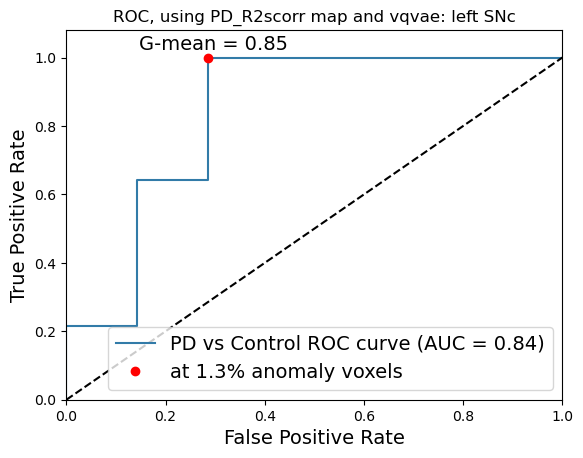

In [16]:
map_type = 'PD_R2scorr'
atlas_type = 'pd25'
ae_type = 'vqvae'
re_map_type = 'l1_re_map'
label_number = 5
roi_type = ['left_subthalamic_nucleus']
quant = 'q0.98'

save_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
final_results = pd.read_csv(save_path / f'final_results_{map_type}_{atlas_type}.csv')
final_results = rename_labels(final_results, atlas_type)

exp_scores, targets = get_classification_results(map_type, ae_type, re_map_type, atlas_type, compute_metrics=False)
pred_scores = np.reshape(np.asarray(exp_scores[label_number][quant]), (-1, 1))

exp_df = final_results.loc[(final_results.ae_type == ae_type) & (final_results.re_map_type == re_map_type)  & (final_results.label.isin(roi_type)), ['label', 'quant', 'gmean', 'auroc', 'auprc', 'pat_threshold', 'g_means']]
gmean_val = exp_df.loc[(exp_df.quant == quant), 'gmean'].values[0]
pat_thr = exp_df.loc[(exp_df.quant == quant), 'pat_threshold'].values[0]
print(pat_thr, gmean_val)

_ = plot_roc(labels=targets, 
         preds=pred_scores,
         flag=True,
         model_name=ae_type,
         map_type=map_type,  
         roi_name='left SNc',
         pat_thr=pat_thr,
         gmean=gmean_val)

In [104]:
fpr, tpr, thrs = metrics.roc_curve(targets, pred_scores, pos_label=1)
print(fpr, tpr, thrs)

[0.         0.         0.14285714 0.14285714 0.28571429 0.28571429
 0.42857143 0.42857143 1.         1.        ] [0.         0.07142857 0.07142857 0.35714286 0.35714286 0.5
 0.5        0.71428571 0.71428571 1.        ] [1.1092437  0.1092437  0.08430233 0.03064067 0.02795699 0.01269036
 0.01149425 0.00775194 0.00265957 0.        ]


In [106]:
print(pat_thr)
np.where(thrs == pat_thr)

0.0129870129870129


(array([], dtype=int64),)

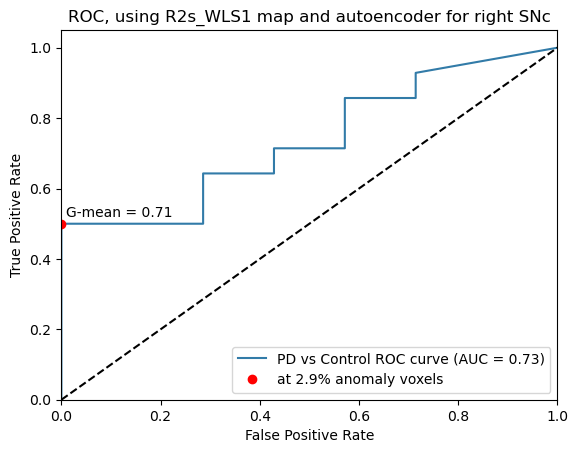

In [88]:
_ = plot_roc(labels=targets, 
         preds=pred_scores,
         flag=True,
         model_name='autoencoder',
         map_type=map_type,  
         roi_name='right SNc',
         pat_thr=pat_thr,
         gmean=gmean_val)

In [86]:
map_type = 'PD_R2scorr'
atlas_type = 'pd25'
save_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
final_results = pd.read_csv(save_path / f'final_results_{map_type}_{atlas_type}.csv')
final_results = rename_labels(final_results, atlas_type)

In [87]:
print(len(final_results))
print(final_results.columns)

2304
Index(['label', 'quant', 'fpr', 'tpr', 'auroc', 'g_means', 'gmean',
       'pat_threshold', 'precision', 'recall', 'auprc', 'map_type', 'ae_type',
       're_map_type'],
      dtype='object')


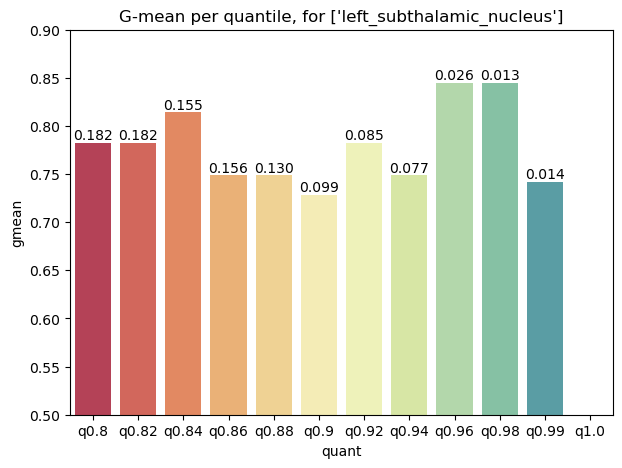

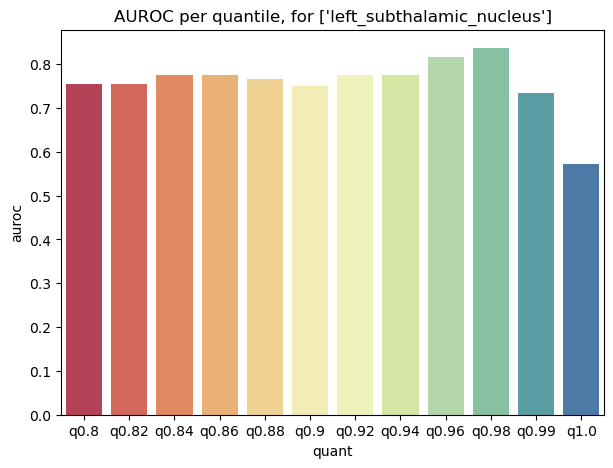

In [89]:
re_map_type = 'l1_re_map'
ae_type = 'vqvae'
roi_type = ['left_subthalamic_nucleus'] # 'left_substantia_nigra', 'right_substantia_nigra'
results_to_plot = final_results.loc[(final_results.ae_type == ae_type) & (final_results.re_map_type == re_map_type)  & (final_results.label.isin(roi_type)), ['label', 'quant', 'gmean', 'auroc', 'auprc', 'map_type', 'ae_type', 're_map_type', 'pat_threshold']]

plt.figure(figsize =(7, 5))
f = sns.barplot(x='quant', y='gmean', data=results_to_plot, palette='Spectral') # legend='full',style='label',  palette='Spectral
plt.title(f'G-mean per quantile, for {roi_type}')
plt.bar_label(f.containers[0], labels=[f'{val:.3f}' for val in results_to_plot.pat_threshold.values])
plt.ylim(0.5, 0.9)
plt.show()

plt.figure(figsize =(7, 5))
f = sns.barplot(x='quant', y='auroc', data=results_to_plot, palette='Spectral') # legend='full',style='label',  palette='Spectral
plt.title(f'AUROC per quantile, for {roi_type}')
plt.show()

In [33]:
results_to_plot.loc[:, ['gmean', 'pat_threshold', 'quant']]

,gmean,pat_threshold,quant
612,0.755929,0.291139,q0.8
613,0.755929,0.269439,q0.82
614,0.755929,0.248193,q0.84
615,0.755929,0.221569,q0.86
616,0.755929,0.188065,q0.88
617,0.755929,0.162749,q0.9
618,0.707107,0.137349,q0.92
619,0.699854,0.098795,q0.94
620,0.699854,0.065099,q0.96
621,0.707107,0.045098,q0.98


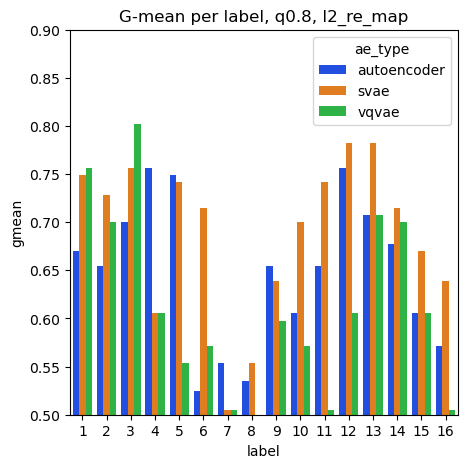

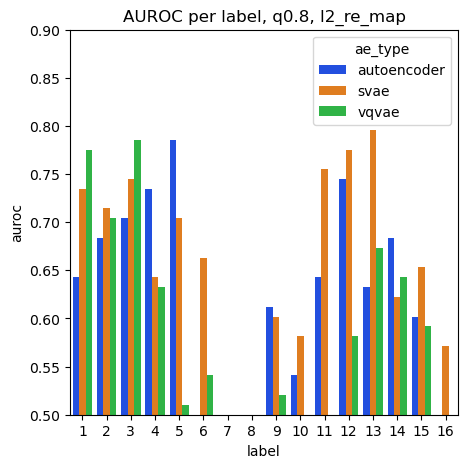

In [34]:
quantil = 'q0.8'
error = 'l2_re_map'
f = plt.figure(figsize=(5,5))
results_to_plot = final_results.loc[(final_results.quant == quantil) & (final_results.re_map_type == error), ['label', 'quant', 'gmean', 'auroc', 'auprc', 'map_type', 'ae_type', 're_map_type']]
sns.barplot(x='label', y='gmean', data=results_to_plot, hue='ae_type', palette='bright') # legend='full',style='label',  palette='Spectral
plt.title(f'G-mean per label, {quantil}, {error}')
plt.ylim(0.5, 0.9)
plt.show()

f = plt.figure(figsize=(5,5))
results_to_plot = final_results.loc[(final_results.quant == quantil) & (final_results.re_map_type == error), ['label', 'quant', 'gmean', 'auroc', 'auprc', 'map_type', 'ae_type', 're_map_type']]
sns.barplot(x='label', y='auroc', data=results_to_plot, hue='ae_type', palette='bright') # legend='full',style='label',  palette='Spectral
plt.title(f'AUROC per label, {quantil}, {error}')
plt.ylim(0.5, 0.9)
plt.show()

# results_to_plot = final_results.loc[final_results.quant.isin(['q0.96', 'q0.99']), ['label', 'quant', 'gmean', 'auroc', 'auprc']]
# sns.barplot(x='label', y='gmean', data=results_to_plot, hue='quant', palette='bright') # legend='full',style='label',  palette='Spectral

# results_to_plot = final_results.loc[final_results.quant.isin(['q0.96', 'q0.99']), ['label', 'quant', 'gmean', 'auroc', 'auprc']]
# sns.barplot(x='label', y='gmean', data=results_to_plot, hue='quant', palette='bright') # legend='full',style='label',  palette='Spectral



<Axes: xlabel='label', ylabel='gmean'>

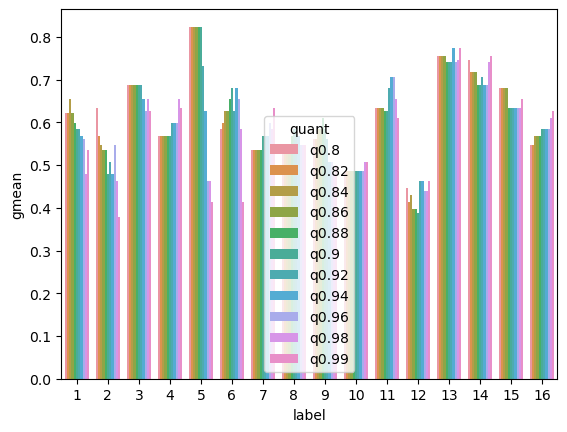

In [161]:
sns.barplot(x='label', y='gmean', hue='quant', data=class_results) # .loc[class_results.auroc > 0.6, :] 

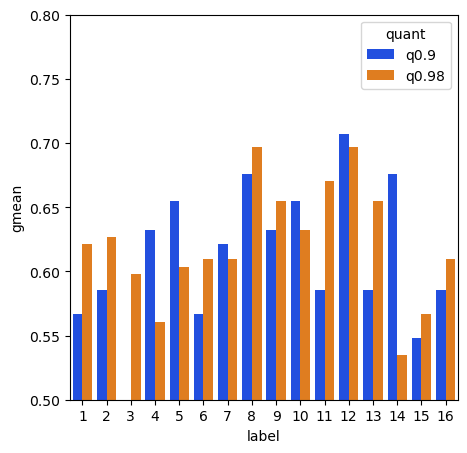

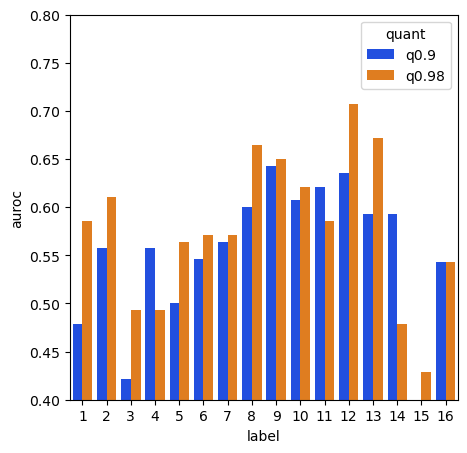

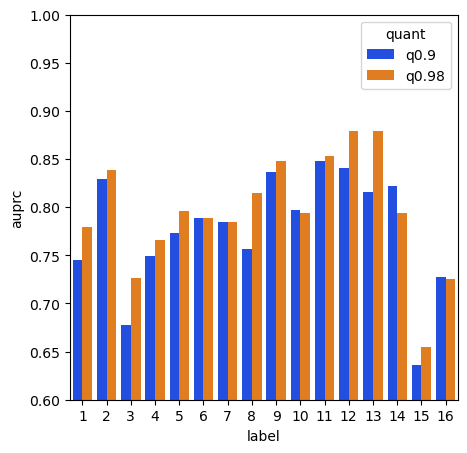

In [21]:
results_to_plot = class_results.loc[class_results.quant.isin(['q0.9', 'q0.98']), ['label', 'quant', 'gmean', 'auroc', 'auprc']]
f = plt.figure(figsize=(5,5))
sns.barplot(x='label', y='gmean', data=results_to_plot, hue='quant', palette='bright') # legend='full',style='label',  palette='Spectral
plt.ylim(0.5, 0.8)
plt.show()
f = plt.figure(figsize=(5,5))
sns.barplot(x='label', y='auroc', data=results_to_plot, hue='quant', palette='bright') # legend='full',style='label',  palette='Spectral
plt.ylim(0.4, 0.8)
plt.show()
f = plt.figure(figsize=(5,5))
sns.barplot(x='label', y='auprc', data=results_to_plot, hue='quant', palette='bright') # legend='full',style='label',  palette='Spectral
plt.ylim(0.6, 1)
plt.show()

<Axes: xlabel='quant', ylabel='gmean'>

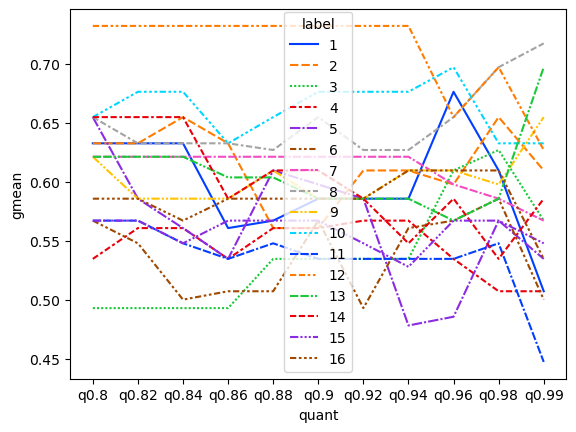

In [152]:
esults_to_plot = class_results #.loc[class_results.label == 12, :]
# sns.lineplot(x='quant', y='auroc', data=results_to_plot, legend='full', hue='label', style='label',palette='bright') # style='label',  palette='Spectral
sns.lineplot(x='quant', y='gmean', data=results_to_plot, legend='full', hue='label',style='label',palette='bright') # style='label',  palette='Spectral

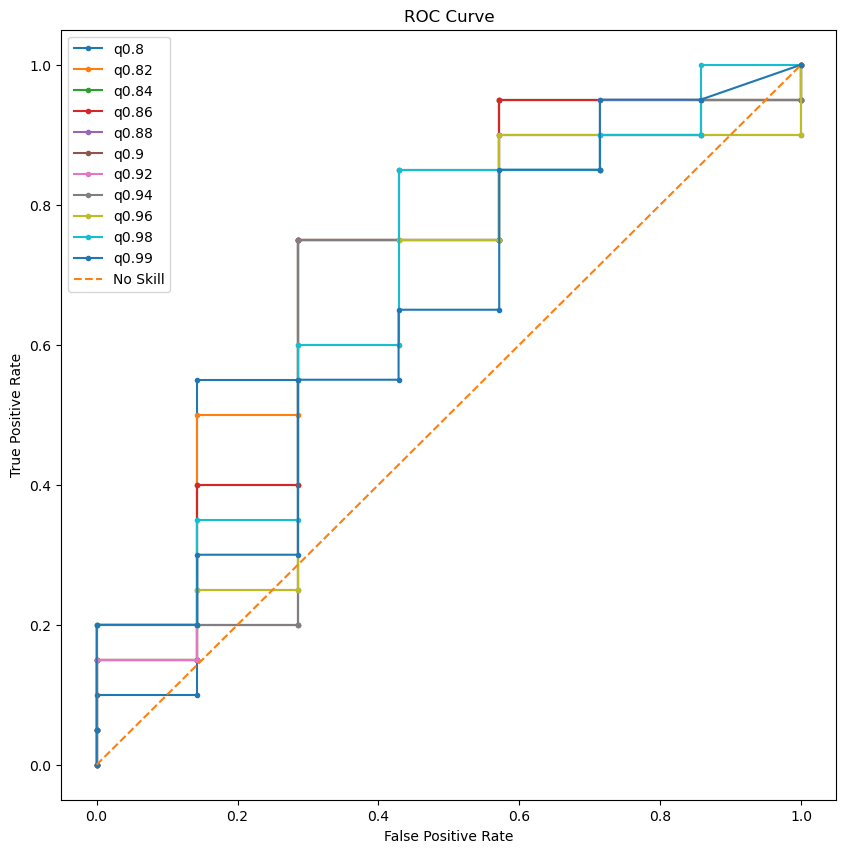

In [124]:
# plot the roc curve for the model
quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99']
f = plt.figure(figsize=(10,10))
for quant in quantiles:
    fpr = class_results.loc[(class_results.label == 12) & (class_results.quant == quant), 'fpr'].values[0]
    tpr = class_results.loc[(class_results.label == 12) & (class_results.quant == quant), 'tpr'].values[0]
    plt.plot(fpr, tpr, marker='.', label=quant)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# show the plot
plt.show()

[0.         0.14285714 0.14285714 0.28571429 0.28571429 0.42857143
 0.42857143 0.57142857 0.57142857 0.71428571 0.71428571 0.85714286
 0.85714286 1.         1.        ]
[0.   0.   0.1  0.1  0.35 0.35 0.5  0.5  0.6  0.6  0.8  0.8  0.95 0.95
 1.  ]


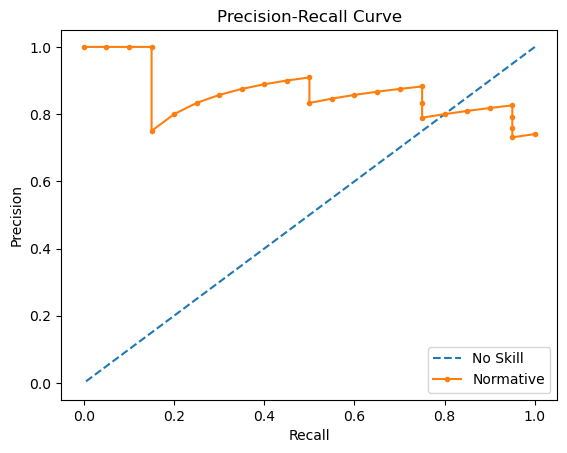

In [106]:
# plot the roc curve for the model
precision = class_results.loc[(class_results.label == 12) & (class_results.quant == 'q0.82'), 'precision'].values[0]
print(fpr)
recall = class_results.loc[(class_results.label == 12) & (class_results.quant == 'q0.82'), 'recall'].values[0]
print(tpr)
plt.plot([1,0], [1,0], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Normative')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
# show the plot
plt.show()

In [ ]:
# metrics.RocCurveDisplay.from_predictions(targets, 
#                                          scores[12]['q0.82'],
#                                          pos_label=1,
#                                          drop_intermediate=True)
# plt.show()

# metrics.PrecisionRecallDisplay.from_predictions(targets,
#                                                 scores[12]['q0.82'],
#                                                 pos_label=1)
# plt.show()

### Group differences XAI maps

In [ ]:
import torchio as tio

In [3]:
def scale_image_w_clip(image, min_percentile=0.2, max_percentile=99.8):
    """Scale image between 0 and 1."""
    image_min = np.percentile(image, min_percentile)
    image_max = np.percentile(image, max_percentile)
    image = np.clip(image, image_min, image_max)
    image = (image - image_min) / (image_max - image_min)
    return image

def min_max_scale(image):
    """Scale image between 0 and 1."""
    image_min = np.min(image)
    image_max = np.max(image)
    image = (image - image_min) / (image_max - image_min)
    return image

In [3]:
hc_subjects = ['sub-036', 'sub-030', 'sub-032', 'sub-050']
pd_subjects = ['sub-041', 'sub-035', 'sub-071', 'sub-015']
maps = ['ig', 'occ']
atlas_type = 'pd25'
map_type = 'R2s_WLS1'
do_scale = True

if do_scale:
    df_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/dfs/statistics_{atlas_type}_{map_type}.csv')
else:
    df_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/dfs/statistics_{atlas_type}_{map_type}_noscale.csv')
if df_path.exists():
    dfs = pd.read_csv(df_path)
else:
    dfs = pd.DataFrame()
    for subject in hc_subjects:
        for re_map in maps:
            base_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/xai')
            if re_map == 'ig':
                map_path = base_path / f'odim_final_{subject}_{map_type}_IntegratedGrads_nsteps_200_result.nii.gz'
            else:
                map_path = base_path / f'odim_final_{subject}_{map_type}_occ_s5_ps8_occ_result.nii.gz'
            map_img = nib.load(str(map_path)).get_fdata()
            if do_scale:
                map_img = min_max_scale(map_img)
                # map_img = scale_image_w_clip(map_img)
            df = get_statistics_from_map(map_img, subject, 'HC', atlas_type=atlas_type)
            df['map_type'] = re_map
            df['scale'] = do_scale
            dfs = pd.concat([dfs, df], axis=0)
        # break

    for subject in pd_subjects:
        for re_map in maps:
            base_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/xai')
            if re_map == 'ig':
                map_path = base_path / f'odim_final_{subject}_{map_type}_IntegratedGrads_nsteps_200_result.nii.gz'
            else:
                map_path = base_path / f'odim_final_{subject}_{map_type}_occ_s5_ps8_occ_result.nii.gz'
            map_img = nib.load(str(map_path)).get_fdata()
            if do_scale:
                map_img = min_max_scale(map_img)
                # map_img = scale_image_w_clip(map_img)
            df = get_statistics_from_map(map_img, subject, 'PD', atlas_type=atlas_type) 
            df['map_type'] = re_map
            df['scale'] = do_scale
            dfs = pd.concat([dfs, df], axis=0)
        # break
    dfs.reset_index(drop=True, inplace=True)
    dfs.to_csv(df_path, index=False)

dfs = rename_labels(dfs, atlas_type)

In [4]:
fos_type = 'mean'
test_stats = []
for map in maps: 
    for label in dfs.label.unique():
        # label = 26
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        # print(f'Processing {map} {label}')
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                   df_lab.loc[df_lab.group == 'HC', fos_type].values)
        t_test, t_p_value = ttest_ind(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                      df_lab.loc[df_lab.group == 'HC', fos_type].values,
                                      equal_var=True,
                                      permutations=1000)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        test_dict['t_test'] = t_test
        test_dict['t_p_value'] = t_p_value
        test_stats.append(test_dict)
        
test_stats = pd.DataFrame(test_stats)

alpha = 0.05
bestfos = test_stats.loc[(test_stats.p_value < alpha) & (test_stats.t_p_value < alpha), :] # (test_stats.p_value < alpha) & 
bestfos.reset_index(drop=True, inplace=True)
bestfos


,map,fos_type,label,f_oneway,p_value,t_test,t_p_value
0,ig,mean,left_globus_pallidus_externa,16.387904,0.006740,4.048198,0.028571
1,ig,mean,right_globus_pallidus_externa,7.855617,0.031050,2.802787,0.028571
2,ig,mean,left_globus_pallidus_interna,12.153809,0.013043,3.486231,0.028571
3,ig,mean,right_globus_pallidus_interna,7.853158,0.031068,2.802349,0.028571


In [6]:
def rename_labels_for_plot(df, atlas_type: str = 'pd25'):

    if atlas_type == 'pd25':
        replace_dict = {'left_red_nucleus': 'left RN',
                        'left_substantia_nigra': 'left SNc',
                        'left_subthalamic_nucleus': 'left STN',
                        'left_caudate': 'left Cau',
                        'left_putamen': 'left Put',
                        'left_globus_pallidus_externa': 'left GPe',
                        'left_globus_pallidus_interna': 'left GPi',
                        'left_thalamus': 'left Th',
                        'right_red_nucleus': 'right RN',
                        'right_substantia_nigra': 'right SNc',
                        'right_subthalamic_nucleus': 'right STN',
                        'right_caudate': 'right Cau',
                        'right_putamen': 'right Put',
                        'right_globus_pallidus_externa': 'right GPe',
                        'right_globus_pallidus_interna': 'right GPi',
                        'right_thalamus': 'right Th'}
        df.label.replace(replace_dict, inplace=True)
        
        return df
    else:
        # replace_dict = {0: 'background',
        #                 2: 'left_cerebral_white_matter',
        #                 3: 'left_cerebral_cortex',
        #                 4: 'left_lateral_ventricle',
        #                 5: 'left_inferior_lateral_ventricle',
        #                 7: 'left_cerebellum_white_matter',
        #                 8: 'left_cerebellum_cortex',
        #                 10: 'left_thalamus',
        #                 11: 'left_caudate',
        #                 12: 'left_putamen',
        #                 13: 'left_pallidum',
        #                 14: 'third_ventricle',
        #                 15: 'fourth_ventricle',
        #                 16: 'brain_stem',
        #                 17: 'left_hippocampus',
        #                 18: 'left_amygdala',
        #                 24: 'csf',
        #                 26: 'left_accumbens_area',
        #                 28: 'left_ventral_diencephalon',
        #                 41: 'right_cerebral_white_matter',
        #                 42: 'right_cerebral_cortex',
        #                 43: 'right_lateral_ventricle',
        #                 44: 'right_inferior_lateral_ventricle',
        #                 46: 'right_cerebellum_white_matter',
        #                 47: 'right_cerebellum_cortex',
        #                 49: 'right_thalamus',
        #                 50: 'right_caudate',
        #                 51: 'right_putamen',
        #                 52: 'right_pallidum',
        #                 53: 'right_hippocampus',
        #                 54: 'right_amygdala',
        #                 58: 'right_accumbens_area',
        #                 60: 'right_ventral_diencephalon'}
        # df.label.replace(replace_dict, inplace=True)

        return df

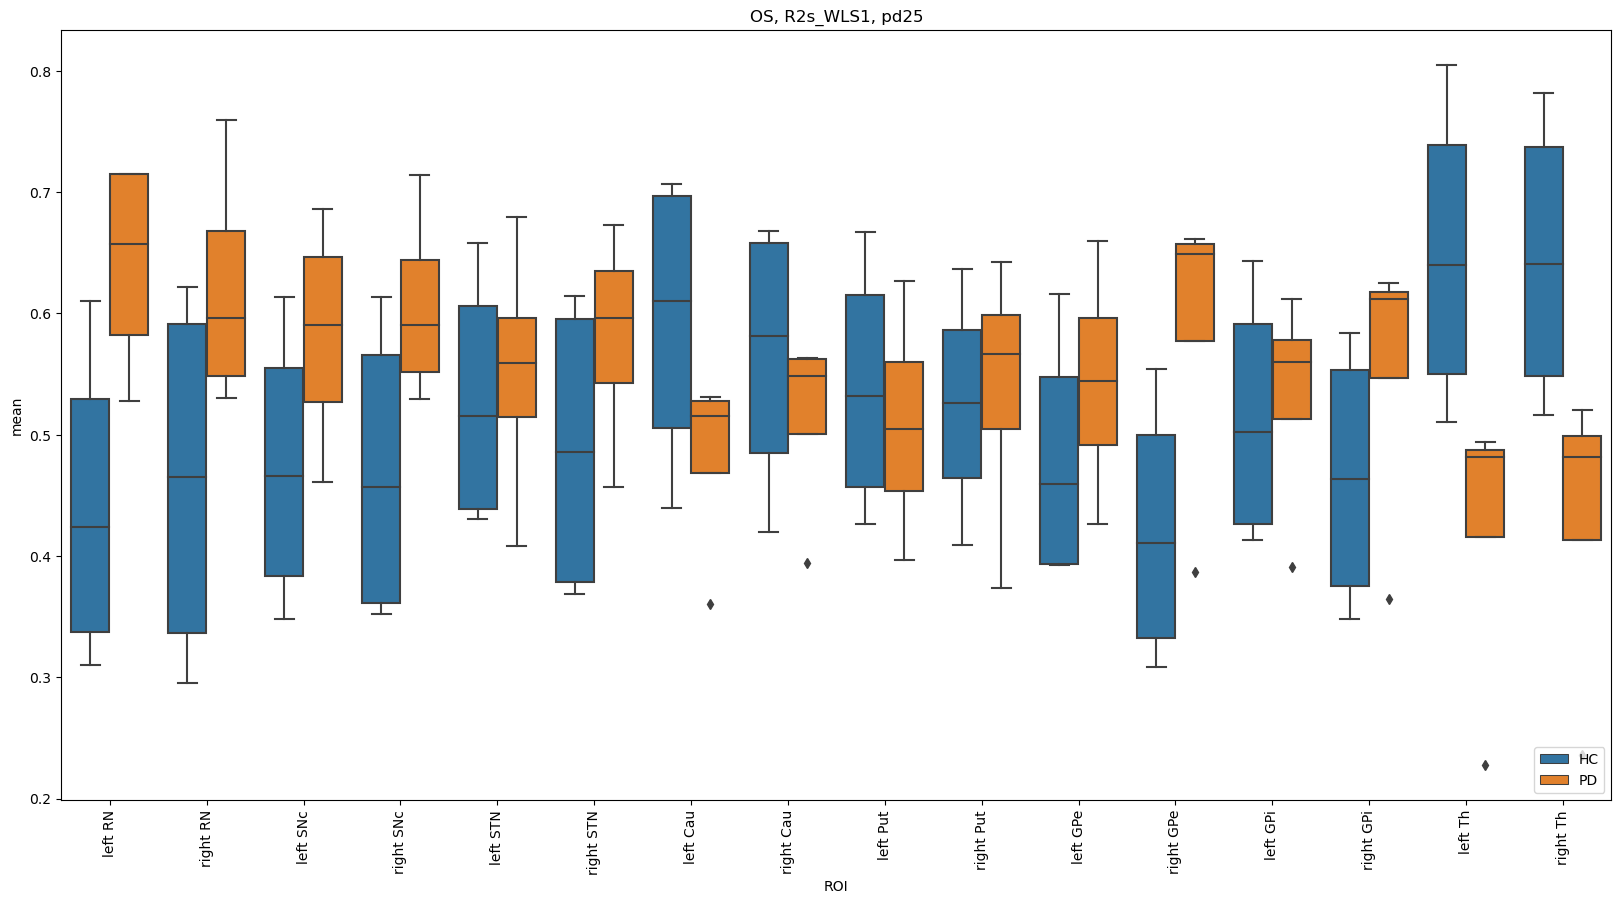

In [11]:
df_to_plot = rename_labels_for_plot(dfs.loc[(dfs.map_type == 'occ') & (dfs.label != 0) , :] , atlas_type) # & (dfs.label.isin(bestfos.loc[bestfos.map == 'ig', :].label.unique()))  & (dfs.label != 0)
plt.figure(figsize=(20,10))
sns.boxplot(x='label', y='mean', hue='group', data=df_to_plot) # & (dfs.label.isin(bestfos.label.unique()))
# plt.xticks(ticks=[0, 1, 2, 3], labels=['left cerebral \n white matter', 'left lateral \n ventricle', 'right cerebral \n white matter', 'right lateral \n ventricle']) # ,rotation=90
# plt.xticks(ticks=[0, 1, 2], labels=['left pallidum', 'right caudate', 'right pallidum']) # ,rotation=90
plt.xticks(rotation=90)
# max_mean = df_to_plot.groupby('label')['mean'].max().max()

# for i, row in bestfos.loc[bestfos.map == 'occ', :].iterrows():
#     # statistical annotation
#     i = i-3
#     x1, x2 = i-0.2, i+0.2 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#     y, h, col = max_mean + 0.01, 0.01, 'k'
#     p_value_to_plot = row.p_value
#     plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     plt.text((x1+x2)*.5, y+h+0.002, f"P = {p_value_to_plot:.3f}", ha='center', va='bottom', color=col)
#     # break

# plt.ylim(0.3, max_mean+0.05)
plt.xlabel('ROI')
plt.title(f'OS, {map_type}, {atlas_type}')
plt.legend(loc="lower right")
plt.show()

### Dev

In [65]:
# subjs = {'sub-041': 'PD',
#          'sub-036': 'HC',
#          'sub-035': 'PD',
#          'sub-071': 'PD',
#          'sub-030': 'HC',
#          'sub-015': 'PD',
#          'sub-032': 'HC',
#          'sub-050': 'HC'}
subjs = {'sub-021': 'PD',
         'sub-064': 'HC',
         'sub-042': 'PD',
         'sub-066': 'PD',
         'sub-039': 'PD'}

maps = ['r2s', 'occ', 'ig']
dfs = pd.DataFrame()
for subject, group in subjs.items():
    for xai_map in maps:
        base_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}')
        if xai_map == 'r2s':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_og_img.nii.gz'
        elif xai_map == 'occ':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_occ_result.nii.gz'
        elif xai_map == 'ig':
            map_path = base_path / f'grad_based/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_IntegratedGrads_nsteps_200_result.nii.gz'
        map_img = nib.load(str(map_path)).get_fdata()
        df = get_statistics_from_map(map_img, subject, group, atlas_type='synthseg')
        df['map_type'] = xai_map
        dfs = pd.concat([dfs, df], axis=0)
    # break
dfs.reset_index(drop=True, inplace=True)
dfs


,label,group,subject,mean,std,median,max,min,iqr,map_type
0,0,PD,sub-021,0.073175,0.159834,0.000000,1.000000,0.000000,0.000000,r2s
1,1,PD,sub-021,0.556251,0.137773,0.540562,0.972508,0.311592,0.172323,r2s
2,2,PD,sub-021,0.589647,0.124017,0.571411,0.943677,0.341132,0.168418,r2s
3,3,PD,sub-021,0.657735,0.220869,0.630668,1.000000,0.190870,0.384007,r2s
4,4,PD,sub-021,0.689894,0.267532,0.731393,1.000000,0.137779,0.535777,r2s
...,...,...,...,...,...,...,...,...,...,...
250,12,PD,sub-039,0.000010,0.000008,0.000008,0.000053,-0.000002,0.000010,ig
251,13,PD,sub-039,-0.000002,0.000003,-0.000001,0.000008,-0.000021,0.000004,ig
252,14,PD,sub-039,0.000004,0.000003,0.000003,0.000017,-0.000002,0.000005,ig
253,15,PD,sub-039,-0.000003,0.000003,-0.000002,0.000005,-0.000027,0.000003,ig


In [96]:
# df_ex = pd.read_csv('xai_outs/stats_5subjs_others.csv')
# df_ex.drop('Unnamed: 0', axis=1, inplace=True)
# df_ex.to_csv('xai_outs/stats_5subjs_others.csv', index=False)

/tmp/ipykernel_550499/1739611130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_uncertain['subgroup'] = 'uncertain'


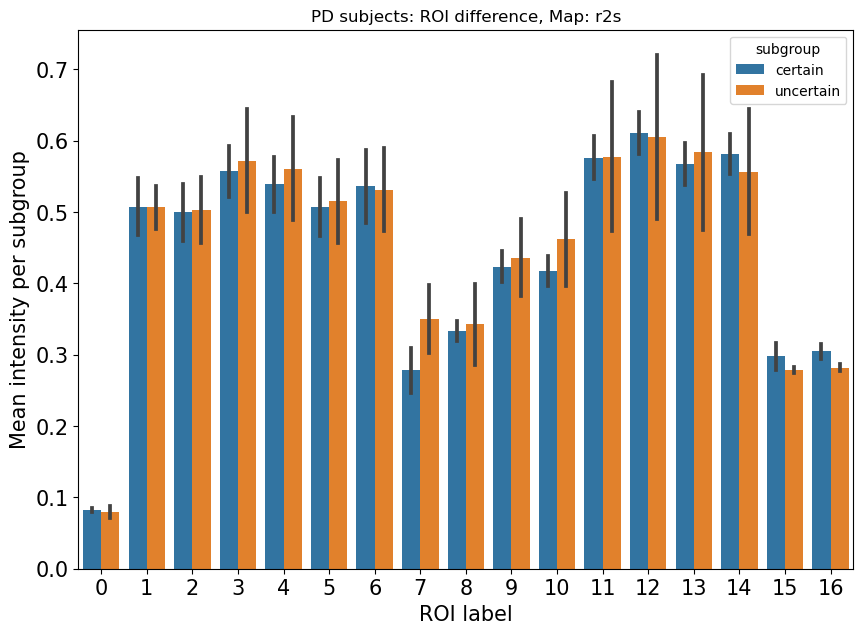

In [116]:
dfs_certain = pd.read_csv('xai_outs/stats_8subj_correct.csv')
dfs_certain = dfs_certain.loc[dfs_certain.group == 'PD']
dfs_certain['subgroup'] = 'certain'
dfs_uncertain = pd.read_csv('xai_outs/stats_5subjs_others.csv')
dfs_uncertain = dfs.loc[dfs.subject.isin(['sub-021', 'sub-042', 'sub-039'])] # correctly classified, close to 0.5 confidence score
dfs_uncertain['subgroup'] = 'uncertain'

map_type = 'r2s'
dfs_all = pd.concat([dfs_certain, dfs_uncertain], axis=0)
df_lab = dfs_all.loc[(dfs_all.map_type == map_type), :]
plt.figure(figsize=(10, 7))
sns.barplot(data=df_lab, x='label', y='mean', hue='subgroup', errorbar='se')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity per subgroup', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'PD subjects: ROI difference, Map: {map_type}')
plt.show()

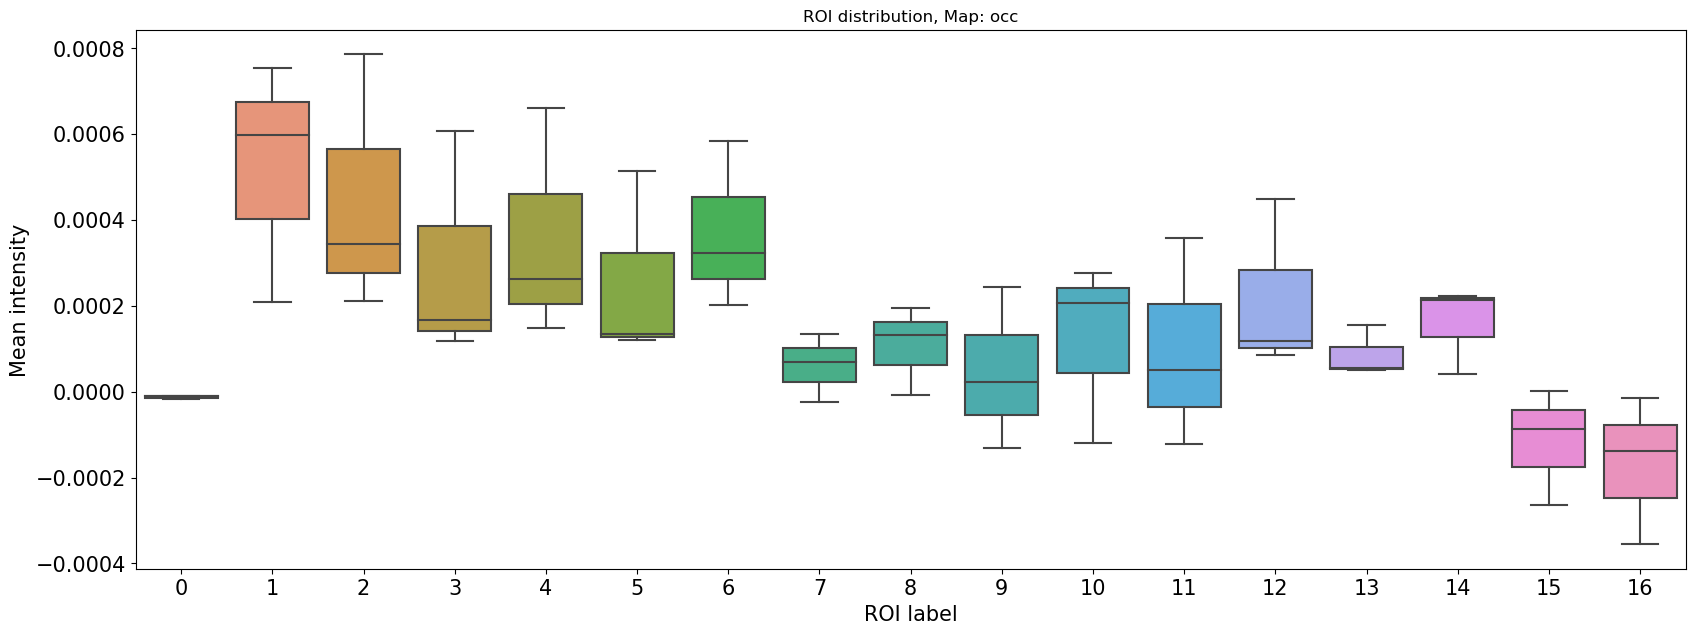

In [68]:
label = 3
map_type = 'occ'
df_lab = dfs_uncertain.loc[(dfs_uncertain.map_type == map_type), :] # & (dfs.map_type == map_type) (dfs.label == label) & 
df_lab
plt.figure(figsize=(20, 7))
sns.boxplot(data=df_lab, x='label', y='mean') #, hue='group') #, hue='map_type')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'ROI distribution, Map: {map_type}')
plt.show()

In [50]:
maps = ['r2s', 'occ', 'ig']
fos_type = 'mean'
f_oneway_stats = []
for map in maps: 
    for label in range(17):
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, df_lab.loc[df_lab.group == 'HC', fos_type].values)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        f_oneway_stats.append(test_dict)

In [57]:
df = pd.DataFrame(f_oneway_stats)

In [58]:
replace_dict = {1: 'left_red_nucleus',
                3: 'left_substantia_nigra',
                5: 'left_subthalamic_nucleus',
                7: 'left_caudate',
                9: 'left_putamen',
                11: 'left_globus_pallidus_externa',
                13: 'left_globus_pallidus_interna',
                15: 'left_thalamus',
                2: 'right_red_nucleus',
                4: 'right_substantia_nigra',
                6: 'right_subthalamic_nucleus',
                8: 'right_caudate',
                10: 'right_putamen',
                12: 'right_globus_pallidus_externa',
                14: 'right_globus_pallidus_interna',
                16: 'right_thalamus',}
df.label.replace(replace_dict, inplace=True)
# df.to_csv('xai_outs/f_oneway_results.csv')
df.loc[df.p_value <= 0.005, :].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
34,ig,mean,0,150.532214,0.000018
29,occ,mean,right_globus_pallidus_externa,62.538034,0.000217
18,occ,mean,left_red_nucleus,40.315682,0.000715
31,occ,mean,right_globus_pallidus_interna,31.841545,0.001328
25,occ,mean,right_caudate,26.276953,0.002165
47,ig,mean,left_globus_pallidus_interna,24.411281,0.002602
20,occ,mean,left_substantia_nigra,23.902338,0.002741
45,ig,mean,left_globus_pallidus_externa,23.820696,0.002764
19,occ,mean,right_red_nucleus,20.928885,0.003791
23,occ,mean,right_subthalamic_nucleus,20.216903,0.004120


In [60]:
df.loc[df.map == 'r2s'].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
12,r2s,mean,right_globus_pallidus_externa,12.548382,0.012184
14,r2s,mean,right_globus_pallidus_interna,11.746263,0.014018
3,r2s,mean,left_substantia_nigra,7.674527,0.032410
9,r2s,mean,left_putamen,5.885121,0.051447
8,r2s,mean,right_caudate,5.417305,0.058841
11,r2s,mean,left_globus_pallidus_externa,4.706601,0.073115
13,r2s,mean,left_globus_pallidus_interna,4.433884,0.079848
16,r2s,mean,right_thalamus,3.890644,0.096021
4,r2s,mean,right_substantia_nigra,3.833537,0.097974
6,r2s,mean,right_subthalamic_nucleus,2.579824,0.159357


In [24]:
dfs.to_csv('xai_outs/stats_8subj_correct.csv')

In [12]:
dfs = pd.concat([df, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
dfs

,label,subject,mean,std,median,max,min,iqr,map_type,group
0,0,sub-015,0.076171,0.167551,0.000000,1.000000,0.000000,0.000000,R2s,PD
1,1,sub-015,0.482413,0.054449,0.485569,0.612388,0.344587,0.073327,R2s,PD
2,2,sub-015,0.496289,0.049496,0.497482,0.595219,0.315454,0.054686,R2s,PD
3,3,sub-015,0.501879,0.080084,0.493421,0.772590,0.300362,0.103222,R2s,PD
4,4,sub-015,0.488259,0.072331,0.487200,0.814420,0.272929,0.096081,R2s,PD
5,5,sub-015,0.475764,0.050556,0.468585,0.622872,0.377056,0.054226,R2s,PD
6,6,sub-015,0.479547,0.052669,0.482360,0.590177,0.357227,0.060052,R2s,PD
7,7,sub-015,0.338203,0.098976,0.339967,0.995558,0.000000,0.091938,R2s,PD
8,8,sub-015,0.312351,0.109459,0.321444,1.000000,0.000000,0.112033,R2s,PD
9,9,sub-015,0.391403,0.077651,0.388681,0.795950,0.000000,0.105278,R2s,PD


In [63]:
def mask_atlas(subject:str, group: str, save=True):
    anat_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks')
    # read brain mask
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'{subject}_brain_mask_mtsat_w.nii')))

    x_min, x_max, y_min, y_max, z_min, z_max = crop_img(brain_mask, return_dims=True)

    # read atlas
    atlas = sitk.ReadImage(str(anat_path/f'inv_reoriented_{subject}_mT1w_{group}_pd25_PD25-subcortical-1mm_uint8.nii'))
    atlas_nda = sitk.GetArrayFromImage(atlas)
    # crop atlas
    atlas_nda_c = atlas_nda[x_min:x_max, y_min:y_max, z_min:z_max] 
    if save:
        save_sitk_from_nda(atlas_nda_c,
                           anat_path/f'{subject}_PD25-subcortical-1mm_cropped.nii',
                           atlas)
    else:
        return atlas_nda_c

def get_atlas_nda(subject, group):

    # crop PD25 atlas as brain mask and save
    mask_atlas(subject, group)
    og_path = Path(f"/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/")
    
    # set atlas path
    pd25_path = og_path / f'Masks/{subject}_PD25-subcortical-1mm_cropped.nii'
    
    # create tio subject and preprocess
    preprocess = tio.Compose(
            [   tio.ToCanonical(),
                tio.CropOrPad(180, padding_mode='minimum')
            ]
        )
    atlas_tiosubj_o = tio.Subject(image=tio.ScalarImage(pd25_path))
    atlas_tiosubj_p = preprocess(atlas_tiosubj_o)
    atlas_tiosubj_nda = atlas_tiosubj_p['image'][tio.DATA].cpu().numpy()[0]

    return atlas_tiosubj_nda
    